# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
# Выполняем стандартную процедуру - импортируем библиотеку pandas, открываем датасет в формате .csv методом pd.read_csv() 
# и выводим общую информацию о нем.

import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 1 columns):
total_images	last_price	total_area	first_day_exposition	rooms	ceiling_height	floors_total	living_area	floor	is_apartment	studio	open_plan	kitchen_area	balcony	locality_name	airports_nearest	cityCenters_nearest	parks_around3000	parks_nearest	ponds_around3000	ponds_nearest	days_exposition    23699 non-null object
dtypes: object(1)
memory usage: 185.3+ KB


In [3]:
# Что-то пошло не так.. Вместо набора признаков показан один. Похоже разделитель вовсе не запятая. 
# Посмотрим на первые 5 наблюдений в датасете.

data.head()

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


In [4]:
# Действительно, разделителем является '\t'. Добавим в метод pd.read_csv() аргумент sep, позволяющий менять 
# значение разделителя и снова посмотрим на общую информацию о датасете.

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Отлично, заработало.

### Вывод

В датасете 23699 наблюдений и 22 признака, из которых 2 с булевыми значениями, по 3 с целочисленными и объектными. Больше всего признаков с вещественным типом данных - целых 14. Видимо придется хорошенько поработать с заменой типов. Также хорошенько придется поработать с пропущенными значениями - они присутствуют более чем в половине признаков.

Весь датасет занимает порядка 3.7 Мб - оно и неудивительно с таким количеством признаков. При этом исходный датасет с одним значением в каждом наблюдении весил порядка 185 кб!

### Шаг 2. Предобработка данных

In [5]:
# Посмотрим на уникальные значения в каждом признаке. Сделаем это при помощи цикла.

for column in data.columns:
    print(column, data.sort_values(by=column)[column].unique())

total_images [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 35 37 39 42 50]
last_price [1.219e+04 4.300e+05 4.400e+05 ... 4.013e+08 4.200e+08 7.630e+08]
total_area [ 12.   13.   13.2 ... 631.  631.2 900. ]
first_day_exposition ['2014-11-27T00:00:00' '2014-11-29T00:00:00' '2014-12-04T00:00:00' ...
 '2019-05-01T00:00:00' '2019-05-02T00:00:00' '2019-05-03T00:00:00']
rooms [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 19]
ceiling_height [  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06  

Пройдемся по признакам и проблемам в них (заодно и поизучаем что к чему):

- 'total_images' (количество фотографий объекта недвижимости в объявлении) - проблем с признаком нет, кол-во фото в диапазоне 0...50, тип данных целочисленный.

- 'last_price' (цена объекта недвижимости на момент снятия публикации) - данные находятся в диапазоне порядка 12190...763000000 рублей. Вот это разброс! Начальное значение кажется слишком малым, если только в качестве объекта недвижимости не продавали ржавый кузов от советского авто. Максимальное значение видится просто огромным.. Может многоэтажку продавали или виллу с 10 спальнями на берегу Ладожского озера. Тип данных вещественный, нужно будет привести к целочисленному.

- 'total_area' (площадь объекта недвижимости в квадратных метрах) - проблем с признаком нет, площадь недвижимости в диапазоне 12...900 м2. Видимо последнее значение относится к последнему значению в предыдущем пункте - дорогой, однако, квадратный метр - почти 0.85 млн.рублей. Тип данных вещественный, менять не нужно.

- 'first_day_exposition' (дата публикации) - проблем с признаком нет. Вероятно нужно будет убрать время и оставить только дату, т.к. время в представленных выше данных везде одинаковое и равно 00:00:00. Объявления о продаже недвижимости размещались в течении 4.5 лет примерно с 12.2014 по 04.2019. Тип данных объектный, к которому относятся и даты - менять не нужно.

- 'rooms' (количество комнат) - значения находятся в диапазоне 0...19. Минимум видится ошибочным либо недвижимость с одной кухней. Максимум - 19 комнат. Круто, целая гостиница! Тип данных целочисленный, менять не нужно.

- 'ceiling_height' (высота потолков в метрах) - диапазон значений 1.0...100.0, имеются пропуски. Экстремумы диапазона нереалистичные, нужно проверять (похоже кузов всё-таки продавали). Тип данных вещественный, в изменении не нуждается.

- 'floors_total' (количество этажей в доме) - диапазон значенией 1.0...60.0, имеются пропуски. Значения вопросов не вызывают. Тип данных вещественный, нужно будет привести к целочисленному.

- 'living_area' (жилая площадь в квадратных метрах) - диапазон значенией 2.0...409.7, имеются пропуски. Ох, лишь бы не гроб продавали.. Пусть уж ржавый кузов. Тип данных вещественный, менять не нужно.

- 'floor' (этаж, на котором расположен объект недвижимости) - идеальный по качеству признак! Пропусков нет, артефактов визуально также нет, тип данных целочисленный и в замене не нуждается.

- 'is_apartment' (является ли объект недвижимости апартаментами) - два значения, есть пропуски. Тип данных нужно заменить с объектного на булевый.

- 'studio' (является ли объект недвижимости квартирой-студией) - два значения (булевый тип), пропусков нет.

- 'open_plan' (наличие у объекта недвижимости свободной планировки) - два значения (булевый тип), пропусков нет.

- 'kitchen_area' (площадь кухни в квадратных метрах) - диапазон значений 1.3...112.0, имеются пропуски. Тип данных вещественный, в замене не нуждается.

- 'balcony' (число балконов) - диапазон значений 0...5, выглядит правдоподобно, но имеются пропуски. Тип данных целочисленный, менять не нужно.

- 'locality_name' (название населенного пункта, в котором находится объект недвижимости) - село Шум.. По этому признаку можно изучать географию Ленинградской области. Имеются пропуски. Тип данных объектный (строковый), менять не нужно.

- 'airports_nearest' (расстояние до ближайшего аэропорта в метрах) - значения в диапазоне 0...84869. Есть пропуски. Может капсулу в аэропорту продавали?.. Тип данных вещественный, нужно будет привести к целочисленному.

- 'cityCenters_nearest' (расстояние до центра населенного пункта в метрах) - диапазон значений 181...65968. Выглядит правдоподобно, но есть пропуски + нужно изменить тип данных с вещественного на целочисленный.

- 'parks_around3000' (число парков в радиусе 3 км) - диапазон значений 0...3. Комментарии аналогичны указанным в предыдущем пункте - выглядит правдоподобно, но есть пропуски + нужно изменить тип данных с вещественного на целочисленный.

- 'parks_nearest' (расстояние до ближайшего парка в метрах) - значения в диапазоне 1...3190. Минимум видимо объясняется наличием парка во дворе дома / виллы на берегу Ладожского озера. Есть пропуски. Нужно менять тип данных с вещественного на целочисленный.

- 'ponds_around3000' (число водоёмов в радийсе 3 км) - диапазон значений 0...3. Выглядит правдоподобно, но есть пропуски + нужно изменить тип данных с вещественного на целочисленный. Число парков и водоемов с одинаковыми диапазонами, может и значения данных признаков в каждом наблюдении одинаковые..

- 'ponds_nearest' (расстояние до ближайшего водоёма в метрах) - значения в диапазоне 13...1344. Выглядит правдоподобно, но есть пропуски + нужно изменить тип данных с вещественного на целочисленный.

- 'days_exposition' (продолжительность размещения объявления в днях) - диапазон значений 1...1580. Классика для последних описываемых признаков - значения выглядят правдоподобно, но имеются пропуски + нужно изменить тип данных с вещественного на целочисленный.

Вот и познакомились с данными - теперь нужно устранить проблемы в них (при необходимсоти изменить тип данных и заполнить/удалить пропуски). 

In [6]:
# Сначала поработаем с пропущенными значениями. Посмотрим еще раз в каких столбцах и в каком количестве они присутствуют.

data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
ponds_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
first_day_exposition        0
last_price                  0
total_area                  0
studio                      0
rooms                       0
floor                       0
open_plan                   0
total_images                0
dtype: int64

In [7]:
# Выглядит не сильно радужно. Если в столбцах 'locality_name' и 'floors_total' пропуски можно спокойно удалить, т.к. их менее
# 1%, то столбцы 'ponds_nearest' и 'parks_nearest' содержат более 50% пропусков, а признак 'is_apartment' - практически
# сплошной пропуск.

# Начнем по порядку убывания и посмотрим, что можно сделать с пропусками в столбце 'is_apartment'. Для начала выясним, можно 
# ли по каким-либо признакам определить, является ли недвижимость апартаментами. Посмотрим на описание данных по столбцам в
# наблюдениях с апартаментами и без них.

for column in data.columns:
    if column != 'is_apartment':
        print(data.loc[data['is_apartment'] == True, column].describe(), data.loc[data['is_apartment'] == False, column].describe(), sep='\n')


count    50.0000
mean     11.1600
std       5.9637
min       0.0000
25%       8.0000
50%      11.0000
75%      16.0000
max      20.0000
Name: total_images, dtype: float64
count    2725.000000
mean        9.230092
std         5.485756
min         0.000000
25%         5.000000
50%         9.000000
75%        13.000000
max        21.000000
Name: total_images, dtype: float64
count    5.000000e+01
mean     1.292420e+07
std      1.616967e+07
min      2.150000e+06
25%      4.815750e+06
50%      6.900000e+06
75%      1.246768e+07
max      8.400000e+07
Name: last_price, dtype: float64
count    2.725000e+03
mean     6.522225e+06
std      1.052674e+07
min      5.500000e+05
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      4.013000e+08
Name: last_price, dtype: float64
count     50.000000
mean      83.325800
std       74.015753
min       20.100000
25%       47.800000
50%       64.000000
75%       95.950000
max      507.000000
Name: total_area, dtype: float64
count    2725.0

По представленным выше данным можно выделить следующие характерные особенности, присущие апартаментам:

- высота потолков выше, чем не в апартаментах (в среднем примерно на 0.3 м), значения min / Q1 / Q2 = 2.5 \ 2.8 \ 3.0 м;
 
- располагаются в зданиях с меньшим количеством этажей (медиана - 5 этажей против 9 у неапартаментов, Q3 равен 7 и 16 соответственно, max - 27 и 35);

- в соответствии с пунктом выше зачастую находятся на этажах не выше 5 (среднее 4.5 против 6 у неапартаментов, Q3 равен 5 и 8 соответственно, max - 22 и 32);

- не является студией и без открытой планировки;

- наличие достаточно большой кухни (значения min / Q1 = 5.0 \ 10.0 м2);

- наличие минимум одного балкона;

- в основном расположены в Санкт-Петербурге (в 78% наблюдений);

- вероятно наличие близлежащего парка на расстоянии до 400 м.
 

In [8]:
# Теперь необходимо отфильтровать датасет по характерным для апартаментов значениям и посмотреть на количество полученных
# наблюдений - ориентрировочно их может быть порядка 380 согласно процентному содержанию апартаментов в датасете.

percent_of_apartments = len(data[data['is_apartment'] == True]) / (len(data[data['is_apartment'] == True]) + len(data[data['is_apartment'] == False]))

round(len(data) * percent_of_apartments - len(data[data['is_apartment'] == True]))

377

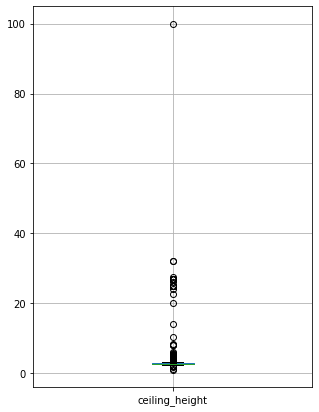

In [9]:
# В ключевых для фильтрации признаках также имеются пропуски, с ними необходимо разобраться до фильтрации. Начнем с высоты
# потолков. Посмотрим на распределение значений по диаграмме размаха. Для этого импортируем модуль pyplot из библиотеки 
# matplotlib.

import matplotlib.pyplot as plt

data.boxplot('ceiling_height', figsize=(5,7))
plt.show()

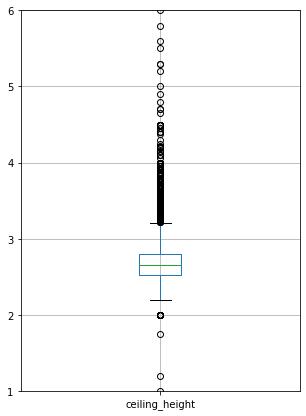

In [10]:
# Есть очевидные выбросы. Приблизим область нормального распределения значений.

data.boxplot('ceiling_height', figsize=(5,7))
plt.ylim(1,6)
plt.show()

In [11]:
# Из диаграммы видно, что нормальное распределение находится в диапазоне 2.2...3.2 м. Примем верхнее значение равным 4.5 м,
# т.к. в коттеджах потолки могут быть выше, чем в квартирах, и по распределению видно достаточно большое кол-во значений за
# правым "усом" (Q3 + 1.5IQR). Т.о., значения менее 2.2 и более 4.5 метров можно заменить на NaN. Посмотрим на количество 
# подобных значений.

len(data.query('ceiling_height < 2.2 or ceiling_height > 4.5'))

56

In [12]:
# Меняем значения вне выбранного диапазона на NaN. Для этого импортируем библиотеку math.

import math

data.loc[data['ceiling_height'] < 2.2, 'ceiling_height'] = math.nan
data.loc[data['ceiling_height'] > 4.5, 'ceiling_height'] = math.nan
data['ceiling_height'].isna().sum()

9251

In [13]:
# Теперь проверим наличие корреяляции между высотой потолков и другими числовыми признаками.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print(column, round(data['ceiling_height'].corr(data[column])*100), sep='\n')
    else:pass

total_images
4.0
last_price
38.0
total_area
48.0
rooms
30.0
ceiling_height
100.0
floors_total
-9.0
living_area
45.0
floor
-5.0
kitchen_area
41.0
balcony
-8.0
airports_nearest
-11.0
cityCenters_nearest
-37.0
parks_around3000
27.0
parks_nearest
-6.0
ponds_around3000
24.0
ponds_nearest
-14.0
days_exposition
13.0


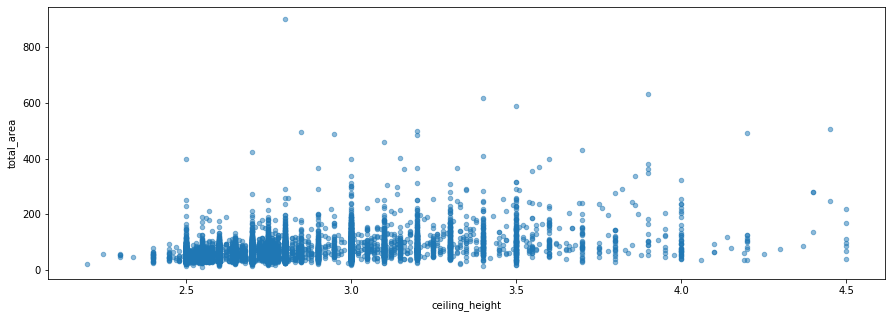

In [14]:
# Сильной корреляции нет ни с одним параметром. Наибольшая из них приходится на общую площадь ('total_area') и составляет 
# 48%. Посмотрим на диаграмму рассеяния 'ceiling_height' и 'total_area'.

data.plot(x='ceiling_height', y='total_area', kind='scatter', alpha=0.5, figsize=(15,5))
plt.show()

In [15]:
# На диаграмме видны типовые высоты потолков (вертикальные линии), но зависимости от общей площади недвижимости 
# ('total_area') действительно нет. Необходимо уменьшить дисперсию значений, объединив их в группы. Посмотрим на наиболее
# часто встречаемые значения высот потолков.

data['ceiling_height'].value_counts().sort_values(ascending= False).head(20)

2.50    3515
2.60    1646
2.70    1574
3.00    1112
2.80     993
2.55     980
2.75     910
2.65     676
3.20     277
3.10     203
2.90     164
3.30     141
2.56     139
3.50     130
2.57     103
2.85     101
3.40      92
2.54      83
2.64      81
2.52      79
Name: ceiling_height, dtype: int64

In [16]:
# Видно, что наиболее часто встречаемые значения изменяются с шагом 0.1 м. Распределим значения высоты потолков по группам 
# с шагом 0.1 м. Например, в группу 2.5 м будут входить значения от 2.50 до 2.59 м.

def ceil_height_cons (ceiling_height):
    if math.isnan(ceiling_height):
        value = math.nan
    else:
        value = math.floor(ceiling_height * 10) / 10
    return value

data['ceiling_height_consolidation'] = data['ceiling_height'].apply(ceil_height_cons)

In [17]:
# Проверим изменение медианного значения относительно базового столбца

data['ceiling_height_consolidation'].median(), data['ceiling_height'].median()

(2.6, 2.65)

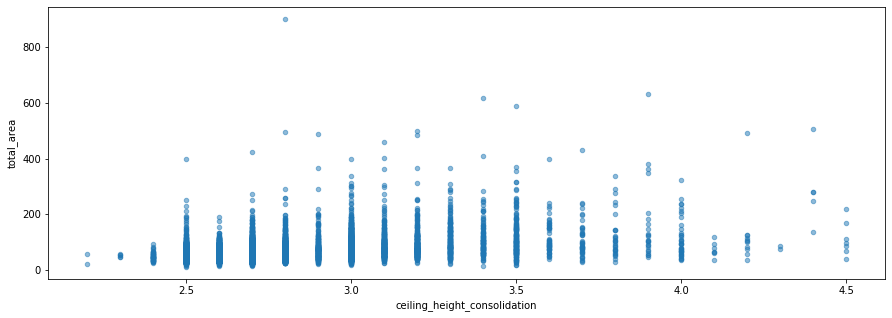

In [18]:
# Медиана уменьшилась всего на 0.05 м. Посмортим на диаграмму рассеяния.

data.plot(x='ceiling_height_consolidation', y='total_area', kind='scatter', alpha=0.5, figsize=(15,5))
plt.show()

In [19]:
# Визуально стало лучше. Посмотрим на корреляцию с общей площадью.

round(data['ceiling_height_consolidation'].corr(data['total_area']) * 100)

48.0

In [20]:
# Корреляция не изменилась. Посмотрим на зависимость сгруппированной высоты потолков и медианного значения общей площади 
# для каждой группы.

data.groupby('ceiling_height_consolidation').agg({'total_area':['median','count']})

total_area      
                                 median count
ceiling_height_consolidation                 
2.2                               40.55     2
2.3                               54.00     5
2.4                               45.90    52
2.5                               46.00  5077
2.6                               50.00  2513
2.7                               53.00  2773
2.8                               60.00  1184
2.9                               70.90   243
3.0                               74.25  1222
3.1                               81.00   325
3.2                               78.65   346
3.3                               97.20   197
3.4                               97.00   117
3.5                              100.50   172
3.6                               96.00    53
3.7                               89.50    42
3.8                              102.00    29
3.9                              106.00    24
4.0                               92.60    40
4.1                               65.60     7
4.2                              104.00    11
4.3                               79.10     2
4.4                              280.00     5
4.5                               95.00     7

In [21]:
# Сгруппированная высота потолков и медианы общей площади имеют явную зависимость. Передадим значения таблицы новой
# переменной и посмотрим на изменение корреляции.

data_ceiling_height_grp = data.groupby('ceiling_height_consolidation').agg({'total_area':['median','count']})
data_ceiling_height_grp.columns = ['median','count']
data_ceiling_height_grp['ceiling_height_cons'] = data_ceiling_height_grp.index
round(data_ceiling_height_grp['ceiling_height_cons'].corr(data_ceiling_height_grp['median']) * 100)

62.0

In [22]:
# Корреляция увеличилась на 14% - движемся в верном направлении. Сделаем выборку для количества значений 'total_area' 
# более 10, т.к. по сводной таблице видно, что значения медиан для высот 2.3 (5 наблюдений), 4.1 (7), 4.3 (2) явно 
# выбиваются из общего тренда. Остальные медианы для количества наблюдений менее 10 также смело можно убрать.

data_ceiling_height_grp = data_ceiling_height_grp.query('count >= 10')
round(data_ceiling_height_grp['ceiling_height_cons'].corr(data_ceiling_height_grp['median']) * 100)

92.0

In [23]:
# Убрав всего лишь 28 наблюдений из практически 14.5 тысяч получилось увеличить корреляцию на 30%. Хорошая эффективность.
# Осталось заполнить пропуски по высоте потолков в исходном датасете. Напишем функцию с учетом полученных значений. Для этого
# часть значений в функции придётся не учитывать.

def ceiling_height_fillna(total_area):
    if total_area <= 46:
        value = 2.5
    elif total_area <= 50:
        value = 2.6
    elif total_area <= 53:
        value = 2.7
    elif total_area <= 60:
        value = 2.8
    elif total_area <= 70.9:
        value = 2.9
    elif total_area <= 74.25:
        value = 3.0
    elif total_area <= 81:
        value = 3.1
    elif total_area <= 97.2:
        value = 3.3
    else: 
        value = 3.5
    
    return value

for row in data.index:
    if math.isnan(data.loc[row, 'ceiling_height_consolidation']):
        data.loc[row, 'ceiling_height_consolidation'] = ceiling_height_fillna(data.loc[row, 'total_area'])
    else:
        pass

In [24]:
# Двигаемся дальше. Далее по списку пропуски встречаются в столбце 'floors_total'. Их 86 - можно спокойно удалить, но
# не будем. Посмотрим на корреляцию данного параметра с другими числовыми признаками.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print(column, round(data['floors_total'].corr(data[column])*100), sep='\n')
    else: pass

total_images
1.0
last_price
-1.0
total_area
-8.0
rooms
-23.0
ceiling_height
-9.0
floors_total
100.0
living_area
-17.0
floor
68.0
kitchen_area
16.0
balcony
19.0
airports_nearest
11.0
cityCenters_nearest
2.0
parks_around3000
-25.0
parks_nearest
10.0
ponds_around3000
-12.0
ponds_nearest
4.0
days_exposition
-5.0
ceiling_height_consolidation
-8.0


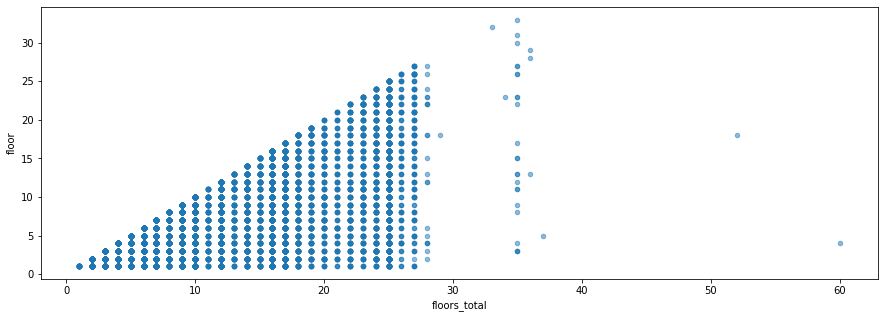

In [25]:
# Достаточно логично наибольшая корреляция (68%) обнаружилась с этажом расположения объекта недвижимости. Посмотрим на 
# соответствующую диаграмму рассеяния.

data.plot(x='floors_total', y='floor', kind='scatter', alpha=0.5, figsize=(15,5))
plt.show()

In [26]:
# Все логично - этаж расположения объекта недвижимости ограничен количеством этажей в здании. Сгруппируем значения по этажам
# и посмотрим на коррелирование между этажом и медианой высоты здания в группе.

data_floor_grp = data.groupby('floor').agg({'floors_total':['median', 'count']})
data_floor_grp.columns = ['median', 'count']
data_floor_grp['floor'] = data_floor_grp.index
round(data_floor_grp['floor'].corr(data_floor_grp['median']) * 100)

98.0

In [27]:
# Какое красивое число, почти целое_трёхзначное. Связь очевидна. Пишем функцию и заполняем пропуски.

def floors_total_fillna(floor):
    if floor <= 4:
        value = 5
    elif floor == 5:
        value = 6
    elif floor == 6:
        value = 9
    elif floor <= 9:
        value = 10
    elif floor <= 12:
        value = 16
    elif floor <= 15:
        value = 17
    elif floor == 16:
        value = 18
    elif floor <= 18:
        value = 22
    elif floor <= 20:
        value = 24
    elif floor <= 25:
        value = 25
    elif floor <= 27:
        value = 27
    else:
        value = 35 # наиболее распространённая этажность для зданий 30+ этажей
    
    return value

for row in data.index:
    if math.isnan(data.loc[row, 'floors_total']):
        data.loc[row, 'floors_total'] = floors_total_fillna(data.loc[row, 'floor'])
    else:
        pass

In [28]:
# Красота по-ленинградски. Переходим к пропускам в столбце 'kitchen_area'. Их 2278. Посмотрим на корреляцию данного 
# параметра с другими числовыми признаками.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print(column, round(data['kitchen_area'].corr(data[column])*100), sep='\n')
    else: pass

total_images
10.0
last_price
52.0
total_area
61.0
rooms
27.0
ceiling_height
41.0
floors_total
16.0
living_area
43.0
floor
14.0
kitchen_area
100.0
balcony
10.0
airports_nearest
1.0
cityCenters_nearest
-19.0
parks_around3000
9.0
parks_nearest
3.0
ponds_around3000
15.0
ponds_nearest
-11.0
days_exposition
10.0
ceiling_height_consolidation
45.0


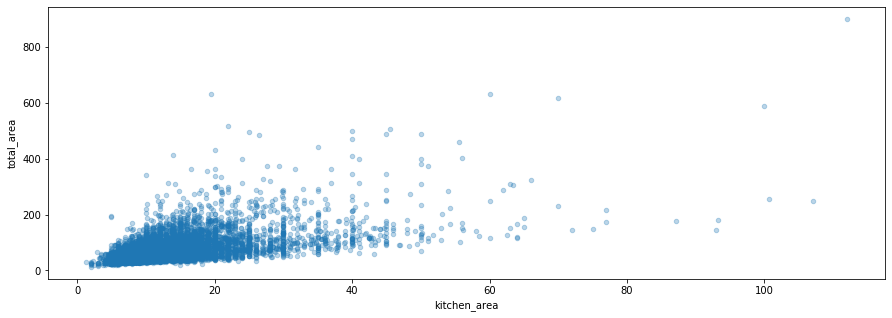

In [29]:
# Опять же логично наибольшая корреляция (61%) выявлена с общей площадью объекта недвижимости. Посмотрим на соответствующую 
# диаграмму рассеяния.

data.plot(x='kitchen_area', y='total_area', kind='scatter', alpha=0.3, figsize=(15,5))
plt.show()

In [30]:
# На диаграмме заметны типовые значения кухонных площадей (вертикальные полосы), но при этом много шума.
# Также необходимо проверить взаимосвязь пропусков кухонных площадей с типом объекта недвижимости - студия, квартира с 
# открытой планировкой, апартаменты. Начнем со студий.

data[data['studio'] == True]['kitchen_area'].value_counts(dropna=False)

NaN    149
Name: kitchen_area, dtype: int64

In [31]:
# Для всех 149 квартир-студий кухонные площади отсутствуют - логично. Пропуски не случайны. Посмотрим на квартиры с
# открытой планировкой.

data[data['open_plan'] == True]['kitchen_area'].value_counts(dropna=False)

NaN    67
Name: kitchen_area, dtype: int64

In [32]:
# Для всех 67 квартир с открытой планировкой кухонные площади отсутствуют, т.о. пропуски также не случайны. 
# Проверим ситуацию с апартаментами.

data[data['is_apartment'] == True]['kitchen_area'].value_counts(dropna=False)

NaN      15
12.00     3
11.00     3
9.00      2
20.00     2
25.00     2
11.70     2
10.00     2
5.50      1
45.00     1
32.00     1
31.00     1
45.50     1
5.00      1
11.37     1
87.20     1
9.50      1
6.50      1
7.00      1
28.00     1
10.20     1
10.29     1
13.60     1
15.90     1
14.46     1
14.04     1
8.00      1
Name: kitchen_area, dtype: int64

In [33]:
# Для апартаментов пропуски по кухонным площадям также не редки, однако встречаются и значения. Т.о. в данном случае 
# пропуски случайны. Создадим новый датасет без студий и открытых планировок для более детальной оценки корреляции кухонной и
# общей площадей объектов недвижимости.

data_wo_studio_openplan = data.query('studio == False and open_plan == False')

In [34]:
# Сгруппируем значения по кухонным площадям и посмотрим на коррелирование между кухонной и общей площадями в группе.

data_kitchen_grp = data_wo_studio_openplan.groupby('kitchen_area').agg({'total_area':['median', 'count']})
data_kitchen_grp.columns = ['median', 'count']
data_kitchen_grp['kitchen_area'] = data_kitchen_grp.index
round(data_kitchen_grp['kitchen_area'].corr(data_kitchen_grp['median']) * 100)

71.0

In [35]:
# +10% к значению первоначальной корреляции. Наверняка в данных много значений с единичным присутствием. Давайте посмотрим. 

round(data_kitchen_grp.query('count == 1')['count'].count() * 100 / data_kitchen_grp['count'].count())

51.0

In [36]:
# 51%. От таких значений нужно избавиться. 

data_kitchen_grp = data_kitchen_grp.query('count > 1')
round(data_kitchen_grp['kitchen_area'].corr(data_kitchen_grp['median']) * 100)

81.0

In [37]:
# Ещё +10%. Всегда бы так. Посмотрим на оставшиеся значения.

data_kitchen_grp['kitchen_area'].value_counts().sort_index(), print('Число значений в выборке', data_kitchen_grp['kitchen_area'].count())

Число значений в выборке 477


(2.0     1
 3.0     1
 3.5     1
 3.8     1
 4.0     1
        ..
 63.0    1
 64.0    1
 65.0    1
 70.0    1
 77.0    1
 Name: kitchen_area, Length: 477, dtype: int64, None)

In [38]:
# Получается 477 уникальных значений. Нужно их унифицировать. Округлим до целого числа - для заполнения пропусков по 
# кухонным площадям этого будет достаточно. Посмотрим на результат.

data_kitchen_grp['kitchen_area'] = data_kitchen_grp['kitchen_area'].round(0)
data_kitchen_grp['kitchen_area'].value_counts().count()

56

In [39]:
# Количество уникальных значений кухонной площади уменьшилось примерно в 8 раз. Сгруппируем данные по округленным значениям 
# и посмотрим, как изменилась корреляция между округленными значениями кухонных площадей и медианными значениями общих
# площадей объектов недвижимости.

data_kitchen_grp.columns = ['median', 'count', 'kitchen_area_round']
data_kitchen_grp = data_kitchen_grp.groupby('kitchen_area_round').agg({'median':'median', 'count':'sum'})
data_kitchen_grp['kitchen_area_round'] = data_kitchen_grp.index
round(data_kitchen_grp['kitchen_area_round'].corr(data_kitchen_grp['median']) * 100)

82.0

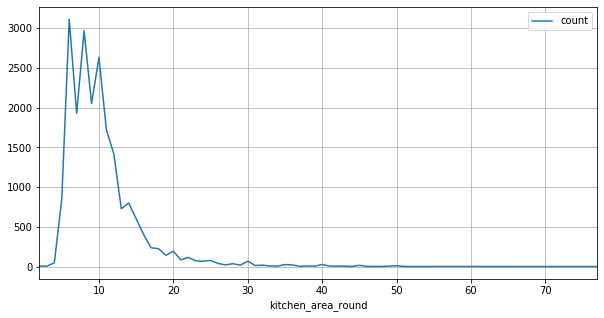

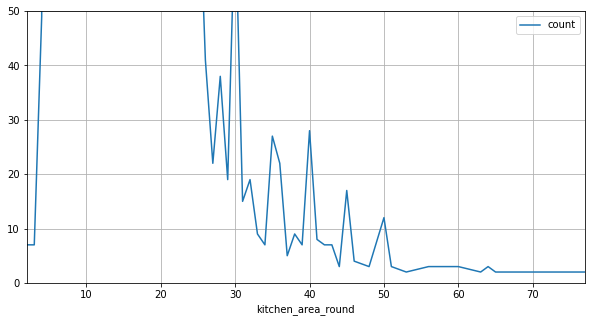

In [40]:
# Практически не изменилась. Посмотрим на распределение по количеству значений округленных кухонных площадей в датасете.  

data_kitchen_grp.plot(x='kitchen_area_round', y='count', grid=True, figsize=(10,5))
plt.show()

data_kitchen_grp.plot(x='kitchen_area_round', y='count', grid=True, figsize=(10,5))
plt.ylim(0,50)
plt.show()

In [41]:
# Основное количество значений приходится на кухонные площади до 30 м2. Далее идет хвост с несколькими локальными всплесками.
# Значения, с количеством менее 10, можно убрать. Посмотрим на изменение корреляции.

data_kitchen_grp = data_kitchen_grp.query('count >= 10')
round(data_kitchen_grp['kitchen_area_round'].corr(data_kitchen_grp['median']) * 100)

93.0

In [42]:
# 93%. Можно писать функцию для заполнения пропусков по рассматриваемому признаку. Для удобства ее написания округлим общие 
# площади объектов недвижимости.

data_kitchen_grp.loc[:,'total_area_round'] = data_kitchen_grp.loc[:,'median'].round(0)
data_kitchen_grp

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,median,count,kitchen_area_round,total_area_round
kitchen_area_round,,,,
4.0,35.7000,49,4.0,36.0
5.0,43.3500,849,5.0,43.0
6.0,44.9250,3110,6.0,45.0
7.0,46.1600,1928,7.0,46.0
8.0,48.9025,2968,8.0,49.0
9.0,45.4500,2052,9.0,45.0
10.0,45.9000,2632,10.0,46.0
11.0,57.4250,1719,11.0,57.0
12.0,61.3000,1419,12.0,61.0


In [43]:
def kitchen_area_fillna(total_area):
    
    if total_area <= 36:
        value = 4
    elif total_area <= 43:
        value = 5
    elif total_area <= 45:
        value = 6
    elif total_area <= 46:
        value = 7
    elif total_area <= 49:
        value = 8
    elif total_area <= 57:
        value = 11
    elif total_area <= 61:
        value = 12
    elif total_area <= 65:
        value = 13
    elif total_area <= 75:
        value = 14
    elif total_area <= 79:
        value = 15
    elif total_area <= 84:
        value = 16
    elif total_area <= 90:
        value = 17
    elif total_area <= 103:
        value = 19
    elif total_area <= 109:
        value = 22
    elif total_area <= 114:
        value = 26
    elif total_area <= 123:
        value = 28
    elif total_area <= 129:
        value = 30
    elif total_area <= 138:
        value = 40
    elif total_area <= 149:
        value = 45
    else: 
        value = 50
    
    return value     

for row in data.index:
    if math.isnan(data.loc[row, 'kitchen_area']) and data.loc[row, 'studio'] == False and data.loc[row, 'open_plan'] == False:
        data.loc[row, 'kitchen_area'] = kitchen_area_fillna(data.loc[row, 'total_area'])
    else:
        pass

In [44]:
# Остальные пропуски для студий и квартир с открытыми планировками заполним значением 0.

data['kitchen_area'].fillna(0, inplace = True)

In [45]:
# Также имеются пропуски в количестве баклонов. Посмотрим на распределение значений в данном признаке.

data['balcony'].value_counts(dropna=False).sort_index()

0.0     3758
1.0     4195
2.0     3659
3.0       81
4.0      183
5.0      304
NaN    11519
Name: balcony, dtype: int64

In [46]:
# Проверим наличие корреляции с другими числовыми признаками.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print(column, round(data['balcony'].corr(data[column])*100), sep='\n')
    else: pass

total_images
12.0
last_price
3.0
total_area
5.0
rooms
2.0
ceiling_height
-8.0
floors_total
19.0
living_area
2.0
floor
17.0
kitchen_area
7.0
balcony
100.0
airports_nearest
7.0
cityCenters_nearest
5.0
parks_around3000
-8.0
parks_nearest
5.0
ponds_around3000
-3.0
ponds_nearest
1.0
days_exposition
-3.0
ceiling_height_consolidation
-5.0


In [47]:
# Ничего примечательного. Дополнительно проверим взаимосвязь пропусков кол-ва балконов с типом объекта недвижимости - студия,
# квартиры с открытой планировкой, апартаменты. Начнем со студий.

data[data['studio'] == True]['balcony'].value_counts(dropna=False)

2.0    61
NaN    58
1.0    18
0.0    12
Name: balcony, dtype: int64

In [48]:
# Квартиры с открытой планировкой.

data[data['open_plan'] == True]['balcony'].value_counts(dropna=False)

2.0    32
1.0    15
NaN    13
0.0     7
Name: balcony, dtype: int64

In [49]:
# Апартаменты.

data[data['is_apartment'] == True]['balcony'].value_counts(dropna=False)

NaN    19
2.0    14
1.0    12
5.0     4
4.0     1
Name: balcony, dtype: int64

In [50]:
# С типом объекта недвижимости зависимости также нет. Очевидно, пропуски в рассматриваемом признаке обусловленны отсутствием
# балкона. Поэтому заменим NaN на 0.

data['balcony'] = data['balcony'].fillna(0)

In [51]:
# Теперь посмотрим на пропуски в территориальном расположении объектов. Всего их 49. Посмотрим на количество уникальных 
# значений.

data['locality_name'].value_counts().count()

364

In [52]:
# На 49 пропусков 364 варианта заполнения. Можно попробовать определить уникальные медианные значения в одном или 
# нескольких признаках для каждого населенного пункта, после чего заполнить пропуски. В преобладающем количестве случаев
# населенным пунктом окажется Санкт-Петербург. На данном этапе предобработки заполним пропуски значением 'н/д'.

data['locality_name'] = data['locality_name'].fillna('н/д')

In [53]:
# Проверим наличие корреляции расстояния до ближайшего парка с другими числовыми признаками.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print(column, round(data['parks_nearest'].corr(data[column])*100), sep='\n')
    else: pass

total_images
-1.0
last_price
-2.0
total_area
-2.0
rooms
-5.0
ceiling_height
-6.0
floors_total
10.0
living_area
-5.0
floor
7.0
kitchen_area
2.0
balcony
3.0
airports_nearest
-7.0
cityCenters_nearest
-4.0
parks_around3000
-26.0
parks_nearest
100.0
ponds_around3000
8.0
ponds_nearest
0.0
days_exposition
2.0
ceiling_height_consolidation
-3.0


In [54]:
# Сильной корреляции нет ни с одним признаком. Посмотрим на значения 'parks_around3000' для наблюдений с пропусками в 
# 'parks_nearest'.

data[data['parks_nearest'].isna()]['parks_around3000'].value_counts(dropna=False)

0.0    10102
NaN     5518
Name: parks_around3000, dtype: int64

In [55]:
# Отлично. Пропуски в 'parks_nearest', где значение в 'parks_around3000' равно 0, заполним значением 3100. Остальные пропуски
# в указанных столбцах соответствуют друг другу (находятся в одних и тех же строках), появление их неслучайно и требует доп.
# анализа.

for index in data.index:
    if math.isnan(data.loc[index, 'parks_nearest']) and data.loc[index, 'parks_around3000'] == 0:
        data.loc[index, 'parks_nearest'] = 3100
    else: pass

In [56]:
# Также проверим, соответствуют ли пропуски в столбце 'ponds_around3000' пропускам в столбцах 'parks_nearest' и 
# 'parks_around3000', т.к. количество данных пропусков одинаково (5518). Проверим и соответствие пропусков в указанных выше
# столбцах и столбцах 'cityCenters_nearest', 'airports_nearest' и 'ponds_nearest' - в первых двух пропусков 5519 и 5542, в
# последнем 14589, но есть подозрение, что большая часть из них связана со значениями в столбце 'ponds_around3000' равными 0,
# как было в случае с 'parks_nearest' и 'parks_around3000'.

print(
    data[data['parks_nearest'].isna()]['ponds_around3000'].value_counts(dropna=False),
    data[data['parks_nearest'].isna()]['cityCenters_nearest'].value_counts(dropna=False),
    data[data['parks_nearest'].isna()]['airports_nearest'].value_counts(dropna=False),
    data[data['parks_nearest'].isna()]['ponds_nearest'].value_counts(dropna=False),
    data[data['ponds_nearest'].isna()]['ponds_around3000'].value_counts(dropna=False), sep = '\n')

NaN    5518
Name: ponds_around3000, dtype: int64
NaN    5518
Name: cityCenters_nearest, dtype: int64
NaN    5518
Name: airports_nearest, dtype: int64
NaN    5518
Name: ponds_nearest, dtype: int64
0.0    9071
NaN    5518
Name: ponds_around3000, dtype: int64


In [57]:
# Бинго. Все предположения подтвердились. Необходимо определить, для каких населенных пунктов характерны пропуски.

locality_park_na = data[data['parks_nearest'].isna()]['locality_name'].value_counts()
locality_park_na

посёлок Мурино           522
Всеволожск               398
Гатчина                  307
деревня Кудрово          299
Выборг                   237
                        ... 
посёлок Дзержинского       1
поселок Гаврилово          1
деревня Кисельня           1
поселок Тёсово-4           1
деревня Трубников Бор      1
Name: locality_name, Length: 345, dtype: int64

In [58]:
# Таких селений аж 345! Посмотрим, для каких населенных пунктов есть значения.

locality_park = data[data['parks_nearest'] > -1]['locality_name'].value_counts()
locality_park

Санкт-Петербург            15660
посёлок Шушары               436
Пушкин                       369
Колпино                      337
посёлок Парголово            327
Петергоф                     201
Сестрорецк                   183
Красное Село                 176
Ломоносов                    132
Кронштадт                     95
посёлок Металлострой          66
посёлок Стрельна              44
н/д                           41
Павловск                      38
Зеленогорск                   24
посёлок Понтонный             20
посёлок Сапёрный               6
посёлок Молодёжное             5
посёлок Репино                 4
посёлок Песочный               4
поселок Мурино                 2
посёлок Александровская        2
посёлок Усть-Ижора             2
посёлок Лисий Нос              2
поселок Лисий Нос              1
посёлок Белоостров             1
посёлок Левашово               1
посёлок Щеглово                1
посёлок Петро-Славянка         1
Name: locality_name, dtype: int64

In [59]:
# Населенных пунктов с заполненными значениями гораздо меньше. Посмотрим, для каких селений есть как значения, так и 
# пропуски.

locality_park_common = []

for name in locality_park.index:
    if name in locality_park_na.index:
        locality_park_common.append(name)
    else: pass
    
locality_park_common

['Санкт-Петербург',
 'посёлок Шушары',
 'Колпино',
 'Красное Село',
 'Ломоносов',
 'Кронштадт',
 'н/д',
 'поселок Мурино',
 'посёлок Щеглово']

In [60]:
# Проверим долю пропущенных значений для указанных выше населенных пунктов.

locality_park_common_perc = pd.DataFrame(data = locality_park_common, columns=['locality_name'])

for index in locality_park_common_perc.index:
    name = locality_park_common_perc.loc[index, 'locality_name']
    total = data.query('locality_name == @name')['locality_name'].count()
    with_na = data[data['parks_nearest'].isna()].query('locality_name == @name')['locality_name'].count()
    locality_park_common_perc.loc[index, 'percent'] = with_na * 100 / total

locality_park_common_perc

,locality_name,percent
0,Санкт-Петербург,0.388016
1,посёлок Шушары,0.909091
2,Колпино,0.295858
3,Красное Село,1.123596
4,Ломоносов,0.751880
5,Кронштадт,1.041667
6,н/д,16.326531
7,поселок Мурино,94.117647
8,посёлок Щеглово,95.652174


In [61]:
# Для большей части рассматриваемых населенных пунктов пропуски составляют менее / около 1%. Т.о., их наличие 
# практически не окажет влияния на точность дальнейших расчётов. Для наблюдений, у которых нет ни одной строки
# с заполненными значениями в столбцах 'ponds_around3000', 'parks_nearest', 'parks_around3000', 'cityCenters_nearest', 
# 'airports_nearest' и 'ponds_nearest' добавим значение True в новый столбец 'many_nan'. И, конечно же, сообщим о наличии 
# неслучайных пропусков специалистам, отвечающим за формирование исследуемого датасета.

data['many_nan'] = False

for index in data[data['parks_nearest'].isna()].index:
    data.loc[index, 'many_nan'] = True

In [62]:
# Остальные пропуски в 'ponds_nearest' заполним значением 3100, т.к. значения 'ponds_around3000' в строках с ними равно 0.

for index in data[data['ponds_nearest'].isna()].index:
    if math.isnan(data.loc[index, 'ponds_nearest']) and data.loc[index, 'ponds_around3000'] == 0:
        data.loc[index, 'ponds_nearest'] = 3100
    else: pass

In [63]:
# Посмотрим, какие пропуски осталось обработать.

data[data['many_nan'] == False].isna().sum().sort_values(ascending=False)

is_apartment                    16034
ceiling_height                   6656
days_exposition                  2316
living_area                      1280
airports_nearest                   24
cityCenters_nearest                 1
many_nan                            0
last_price                          0
total_area                          0
first_day_exposition                0
rooms                               0
floors_total                        0
floor                               0
open_plan                           0
studio                              0
ceiling_height_consolidation        0
kitchen_area                        0
balcony                             0
locality_name                       0
parks_around3000                    0
parks_nearest                       0
ponds_around3000                    0
ponds_nearest                       0
total_images                        0
dtype: int64

In [64]:
# Остался один необработанный пропуск в столбце 'cityCenters_nearest'. Посмотрим на него.

data[(data['many_nan'] == False) & (data['cityCenters_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
20190,2,10500000.0,85.0,2019-01-08T00:00:00,3,3.0,3.0,55.5,2,NaN,...,Пушкин,15527.0,NaN,1.0,134.0,0.0,3100.0,NaN,3.0,False


In [65]:
# Случайный пропуск в городе Пушкин. Посмотрим на остальные строки с данным городом.

data[data['locality_name'] == 'Пушкин'].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
14,1,4400000.0,36.0,2016-06-23T00:00:00,1,NaN,6.0,17.0,1,NaN,...,Пушкин,20782.0,30759.0,0.0,3100.0,1.0,96.0,203.0,2.5,False
28,8,4170000.0,44.0,2017-12-13T00:00:00,1,2.9,6.0,20.8,1,NaN,...,Пушкин,18557.0,30710.0,0.0,3100.0,1.0,118.0,74.0,2.9,False
50,1,4500000.0,48.2,2017-11-13T00:00:00,1,2.7,5.0,25.4,4,False,...,Пушкин,19841.0,30183.0,1.0,531.0,3.0,330.0,152.0,2.7,False
109,2,7497600.0,62.5,2015-12-08T00:00:00,2,NaN,5.0,35.5,5,NaN,...,Пушкин,14517.0,26670.0,1.0,517.0,0.0,3100.0,1048.0,2.9,False
126,10,4050000.0,51.0,2019-04-23T00:00:00,2,NaN,5.0,30.5,1,NaN,...,Пушкин,17974.0,32546.0,1.0,15.0,1.0,659.0,NaN,2.7,False
140,8,16912000.0,105.7,2016-12-09T00:00:00,2,2.7,3.0,48.4,1,NaN,...,Пушкин,14352.0,26506.0,3.0,366.0,3.0,179.0,390.0,2.7,False
387,9,6630000.0,65.0,2018-03-23T00:00:00,2,NaN,5.0,26.0,3,NaN,...,Пушкин,21037.0,31413.0,0.0,3100.0,1.0,405.0,98.0,2.9,False
419,5,4150000.0,38.0,2017-02-21T00:00:00,1,NaN,5.0,16.0,5,NaN,...,Пушкин,20562.0,30937.0,0.0,3100.0,1.0,349.0,654.0,2.5,False
439,9,8570000.0,72.0,2018-08-11T00:00:00,3,3.0,6.0,42.0,4,NaN,...,Пушкин,14691.0,26845.0,0.0,3100.0,0.0,3100.0,149.0,3.0,False
474,7,5700000.0,67.2,2017-06-25T00:00:00,2,3.0,5.0,36.9,4,NaN,...,Пушкин,20138.0,32291.0,0.0,3100.0,0.0,3100.0,306.0,3.0,False


In [66]:
# Бросаются в глаза большие значения в столбце 'cityCenters_nearest'. Очевидно расстояния приводятся до центра 
# Санкт-Петербурга. Взглянув на карту и вспомнив местоположение данного города, предположение подтверждается. При этом, на
# пути к центру Питера располагается аэропорт Пулково. Посчитаем пропущенное значение по соотношению медиан в столбцах  
# 'airports_nearest' и'cityCenters_nearest'.


pushkin_air_median = data[data['locality_name'] == 'Пушкин']['airports_nearest'].median()
pushkin_centr_median = data[data['locality_name'] == 'Пушкин']['cityCenters_nearest'].median()

data.loc[20190,'cityCenters_nearest'] = data.loc[20190,'airports_nearest'] * pushkin_centr_median / pushkin_air_median

In [67]:
# Есть 24 необработанных пропуска в столбце 'airports_nearest'. Посмотрим на них.

data[(data['many_nan'] == False) & (data['airports_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
733,18,18700000.0,109.7,2018-02-03T00:00:00,3,2.75,21.0,57.2,13,NaN,...,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,3100.0,112.0,2.7,False
974,8,25897000.0,149.0,2018-03-26T00:00:00,4,2.74,7.0,NaN,6,NaN,...,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,90.0,2.7,False
2415,17,9500000.0,67.4,2017-04-15T00:00:00,2,2.80,23.0,37.6,4,NaN,...,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,3100.0,56.0,2.8,False
7521,16,43500000.0,245.8,2015-12-17T00:00:00,3,4.45,7.0,170.8,7,True,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,1067.0,4.4,False
7542,10,6900000.0,50.0,2016-03-17T00:00:00,1,2.80,23.0,20.0,12,NaN,...,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,3100.0,317.0,2.8,False
8018,20,84000000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,1078.0,4.4,False
8628,0,8000000.0,48.9,2018-02-23T00:00:00,1,NaN,6.0,NaN,4,NaN,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,60.0,2.6,False
9054,5,13000000.0,71.8,2017-09-12T00:00:00,2,2.75,10.0,32.5,5,NaN,...,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,156.0,2.7,False
9880,11,5300000.0,51.0,2018-01-10T00:00:00,2,NaN,5.0,22.6,4,NaN,...,Санкт-Петербург,NaN,4892.0,0.0,3100.0,2.0,369.0,13.0,2.7,False
10669,9,3400000.0,46.0,2018-09-01T00:00:00,2,2.60,5.0,28.0,5,NaN,...,Санкт-Петербург,NaN,21377.0,0.0,3100.0,0.0,3100.0,106.0,2.6,False


In [68]:
# Все пропуски в питерской недвижимости. Имеются повторяющиеся значения в столбцах 'cityCenters_nearest' и 'parks_nearest'.
# Отсортируем по ним срез данных.

data[(data['many_nan'] == False) & (data['airports_nearest'].isna())].sort_values(by='cityCenters_nearest')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
9880,11,5300000.0,51.0,2018-01-10T00:00:00,2,NaN,5.0,22.6,4,NaN,...,Санкт-Петербург,NaN,4892.0,0.0,3100.0,2.0,369.0,13.0,2.7,False
7521,16,43500000.0,245.8,2015-12-17T00:00:00,3,4.45,7.0,170.8,7,True,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,1067.0,4.4,False
8018,20,84000000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,1078.0,4.4,False
8628,0,8000000.0,48.9,2018-02-23T00:00:00,1,NaN,6.0,NaN,4,NaN,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,60.0,2.6,False
13106,13,27000000.0,116.0,2018-02-01T00:00:00,2,3.40,7.0,78.9,2,NaN,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,NaN,3.4,False
12401,20,91500000.0,495.0,2017-06-19T00:00:00,7,NaN,7.0,347.5,7,NaN,...,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,3100.0,14.0,3.5,False
11457,9,12900000.0,73.5,2017-09-12T00:00:00,2,2.75,10.0,32.9,5,NaN,...,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,156.0,2.7,False
974,8,25897000.0,149.0,2018-03-26T00:00:00,4,2.74,7.0,NaN,6,NaN,...,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,90.0,2.7,False
21769,20,16500000.0,82.7,2018-10-31T00:00:00,2,2.91,25.0,45.7,9,NaN,...,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,NaN,2.9,False
9054,5,13000000.0,71.8,2017-09-12T00:00:00,2,2.75,10.0,32.5,5,NaN,...,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,156.0,2.7,False


In [69]:
# Действительно, уникальных значений всего 7. Попробуем найти их в остальном датасете.

print(data.query('cityCenters_nearest == 4892 ')['airports_nearest'],
      data.query('cityCenters_nearest == 5735 and parks_nearest == 110')['airports_nearest'],
      data.query('cityCenters_nearest == 9734 and parks_nearest == 469')['airports_nearest'],
      data.query('cityCenters_nearest == 11246')['airports_nearest'],
      data.query('cityCenters_nearest == 11835 and parks_nearest == 267')['airports_nearest'],
      data.query('cityCenters_nearest == 13355 and parks_nearest == 735')['airports_nearest'],
      data.query('cityCenters_nearest == 21377')['airports_nearest'], sep = '\n'
     )

9880   NaN
Name: airports_nearest, dtype: float64
7521    NaN
8018    NaN
8628    NaN
12401   NaN
13106   NaN
Name: airports_nearest, dtype: float64
974     NaN
9054    NaN
11457   NaN
14276   NaN
16825   NaN
21769   NaN
Name: airports_nearest, dtype: float64
4687      9823.0
13307    29080.0
21075        NaN
23124        NaN
Name: airports_nearest, dtype: float64
11446   NaN
Name: airports_nearest, dtype: float64
733     NaN
2415    NaN
7542    NaN
16470   NaN
16927   NaN
18222   NaN
18557   NaN
22790   NaN
Name: airports_nearest, dtype: float64
10669   NaN
Name: airports_nearest, dtype: float64


In [70]:
# Найдены варианты расстояний до аэропорта по строкам с расстоянием до центра равным 11246 м. Посмотрим на найденные строки
# и строки с пропусками.

data.loc[[4687, 13307, 21075, 23124], :]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
4687,4,5580000.0,59.0,2018-10-11T00:00:00,4,2.50,5.0,43.0,4,NaN,...,Санкт-Петербург,9823.0,11246.0,0.0,3100.0,0.0,3100.0,NaN,2.5,False
13307,7,5400000.0,54.4,2018-01-17T00:00:00,2,NaN,10.0,30.0,8,NaN,...,Санкт-Петербург,29080.0,11246.0,1.0,546.0,1.0,593.0,21.0,2.8,False
21075,1,3650000.0,48.8,2017-06-24T00:00:00,4,2.50,5.0,37.0,1,NaN,...,Санкт-Петербург,NaN,11246.0,0.0,3100.0,0.0,3100.0,174.0,2.5,False
23124,0,3500000.0,41.3,2018-01-11T00:00:00,3,2.55,5.0,29.5,1,NaN,...,Санкт-Петербург,NaN,11246.0,0.0,3100.0,0.0,3100.0,23.0,2.5,False


In [71]:
# По совокупности значений подходит вариант с расстоянием 9823 м. Им и заполним пропуски.

data.loc[[21075,23124], 'airports_nearest'] = 9823

Остальные 22 пропуска в столбце 'airports_nearest' оставим без изменения.

Напомним характерные для апартаментов признаки.

- высота потолков выше, чем не в апартаментах (в среднем примерно на 0.3 м), значения min / Q1 / Q2 = 2.5 \ 2.8 \ 3.0 м;
 
- располагаются в зданиях с меньшим количеством этажей (медиана - 5 этажей против 9 у неапартаментов, Q3 равен 7 и 16 соответственно, max - 27 и 35);

- в соответствии с пунктом выше зачастую находятся на этажах не выше 5 (среднее 4.5 против 6 у неапартаментов, Q3 равен 5 и 8 соответственно, max - 22 и 32);

- не является студией и без открытой планировки;

- наличие достаточно большой кухни (значения min / Q1 = 5.0 \ 10.0 м2);

- наличие минимум одного балкона;

- в основном расположены в Санкт-Петербурге (в 78% наблюдений);

- вероятно наличие близлежащего парка на расстоянии до 400 м.
 

In [72]:
# Отфильтруем датасет по указанным выше значениям применительно к пропускам в столбце 'is_apartment'.

data_isapartment_fillna = data[data['is_apartment'].isna()].query('balcony > 0 and studio == False and open_plan == False and ceiling_height_consolidation >= 2.8 and floors_total <= 7 and floor <= 5 and kitchen_area >= 10')
data_isapartment_fillna.shape

(298, 24)

In [73]:
# Получившееся количество отфильтрованных наблюдений не превышает 380, как и предполагалось ранее. Посмотрим теперь на 
# населенные пункты, в которых расположены отфильтрованные значения.

data_isapartment_fillna['locality_name'].value_counts()

Санкт-Петербург                           195
Пушкин                                     18
Сестрорецк                                 12
Всеволожск                                  8
Петергоф                                    5
Колпино                                     5
Отрадное                                    4
Кронштадт                                   4
Сертолово                                   4
Гатчина                                     4
посёлок Шушары                              3
Выборг                                      3
Красное Село                                3
Коммунар                                    3
деревня Аро                                 2
Лодейное Поле                               1
посёлок городского типа Кузьмоловский       1
посёлок Репино                              1
городской посёлок Рощино                    1
Кириши                                      1
Кингисепп                                   1
деревня Белогорка                 

In [74]:
# Интересно, в деревнях и поселках строят апартаменты? Давайте проверим.

data[data['is_apartment'] == True]['locality_name'].value_counts()

Санкт-Петербург    39
Выборг              3
Колпино             1
Красное Село        1
Зеленогорск         1
Петергоф            1
Никольское          1
Всеволожск          1
деревня Нижняя      1
посёлок Щеглово     1
Name: locality_name, dtype: int64

In [75]:
# Судя по-всему строят, хотя, конечно, есть в этом сомнения и достоверность данной информации необходимо уточнять. На текущем
# этапе ограничимся отсутствием в названии начеленного пункта значений 'посёлок', 'поселок', 'село', 'деревня', 'н/д' и 
# заменим в оставшихся наблюдениях пропуски столбца 'is_apartment' на True.

exclude_locality = ['посёлок', 'поселок', 'село', 'деревня', 'н/д']

for index in data_isapartment_fillna.index:
    i = 0
    while i in range(len(exclude_locality)):
        if exclude_locality[i] in data_isapartment_fillna.loc[index, 'locality_name']:
            break
        else: i += 1
    if i == len(exclude_locality):
        data.loc[index, 'is_apartment'] = True
    else: pass

In [76]:
# Остальные пропуски заполним значением False.

data['is_apartment'].fillna(False, inplace=True)

In [77]:
# Проверим, в каких столбцах остались пропуски.

print(data[data['many_nan'] == False].isna().sum().sort_values(), 
data.isna().sum().sort_values(), sep= '\n')

total_images                       0
ponds_nearest                      0
ponds_around3000                   0
parks_nearest                      0
parks_around3000                   0
cityCenters_nearest                0
locality_name                      0
balcony                            0
kitchen_area                       0
ceiling_height_consolidation       0
open_plan                          0
is_apartment                       0
floor                              0
floors_total                       0
rooms                              0
first_day_exposition               0
total_area                         0
last_price                         0
studio                             0
many_nan                           0
airports_nearest                  22
living_area                     1280
days_exposition                 2316
ceiling_height                  6656
dtype: int64
total_images                       0
locality_name                      0
balcony                  

In [78]:
# На очереди пропуски в жилой площади помощений. Их целых 1903. Посмотрим с какими числовыми признаками есть корреляции.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print(column, round(data['living_area'].corr(data[column])*100), sep='\n')
    else: pass

total_images
10.0
last_price
57.0
total_area
94.0
rooms
85.0
ceiling_height
45.0
floors_total
-17.0
living_area
100.0
floor
-10.0
kitchen_area
46.0
balcony
-1.0
airports_nearest
-6.0
cityCenters_nearest
-23.0
parks_around3000
18.0
parks_nearest
-14.0
ponds_around3000
15.0
ponds_nearest
-11.0
days_exposition
14.0
ceiling_height_consolidation
57.0


In [79]:
# Выдумывать ничего не нужно - практически максимальная корреляция (94%) с общей площадью помещения. Посмотрим на соотношение
# среднеарифметических и медианных значений общей и жилой площадей.

liv_total_mean = data['living_area'].mean()/data['total_area'].mean()
liv_total_median = data['living_area'].median()/data['total_area'].median()

liv_total_mean, liv_total_median

(0.5709796633031937, 0.5769230769230769)

In [80]:
# Практически одинаковые. Определим по медианному соотношению пропущенные значения жилых площадей.

for index in data.index:
    if math.isnan(data.loc[index, 'living_area']):
        data.loc[index, 'living_area'] = data.loc[index, 'total_area'] * liv_total_median
    else: pass

In [81]:
# Пропуски в днях размещения можно попробовать заполнить на основании даты размещения. Для начала изменим формат даты на 
# читабельный.

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [82]:
# Проверим последнюю дату публикаций.

data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

In [83]:
# Посмотри на наблюдения с последней датой публикации.

data[data['first_day_exposition'] == '2019-05-03 00:00:00']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
2178,10,5100000.0,51.00,2019-05-03,1,NaN,9.0,15.000000,2,False,...,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.7,True
3254,16,8800000.0,80.00,2019-05-03,3,2.80,17.0,31.000000,15,False,...,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,True
4450,13,3500000.0,34.60,2019-05-03,1,2.50,5.0,19.400000,3,False,...,Пушкин,13107.0,25261.0,1.0,361.0,0.0,3100.0,NaN,2.5,False
5986,0,5000000.0,48.00,2019-05-03,3,2.50,9.0,27.692308,2,False,...,Санкт-Петербург,51060.0,16892.0,0.0,3100.0,0.0,3100.0,NaN,2.5,False
8170,4,3280000.0,38.19,2019-05-03,1,NaN,6.0,14.410000,4,False,...,городской посёлок Новоселье,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,True
9217,7,4300000.0,35.70,2019-05-03,1,2.70,21.0,15.000000,12,False,...,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.7,True
10917,20,10000000.0,62.30,2019-05-03,2,NaN,6.0,20.000000,3,False,...,Санкт-Петербург,25083.0,3148.0,2.0,629.0,0.0,3100.0,NaN,2.9,False
12003,10,950000.0,37.10,2019-05-03,1,NaN,4.0,17.000000,4,False,...,деревня Курковицы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,True
12208,7,9000000.0,60.30,2019-05-03,2,3.25,5.0,36.900000,4,False,...,Санкт-Петербург,32302.0,4662.0,1.0,398.0,0.0,3100.0,NaN,3.2,False
12343,12,2890000.0,48.80,2019-05-03,2,2.55,5.0,29.400000,1,False,...,городской посёлок Рощино,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,True


In [84]:
# Продолжительность публикаций не указана. Найдем последнюю дату публикации с указанной продолжительностью.

data[data['days_exposition'].isna() == False]['first_day_exposition'].max()

Timestamp('2019-05-01 00:00:00')

In [85]:
# Посмотрим, когда объявление было снято.

data[(data['first_day_exposition'] == '2019-05-01 00:00:00')&(data['days_exposition'] > 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_height_consolidation,many_nan
1632,19,4000000.0,49.9,2019-05-01,2,2.5,9.0,25.0,1,False,...,Санкт-Петербург,13567.0,14384.0,1.0,20.0,1.0,681.0,1.0,2.5,False


In [86]:
# 2 мая 2019 года. Посмотрим самую старую дату публикации с пропуском в продолжительности размещения объявления.

data[data['days_exposition'].isna()]['first_day_exposition'].sort_values().head(10)

3873    2014-11-27
15857   2014-11-27
3291    2014-11-27
6922    2014-12-08
15614   2014-12-09
260     2014-12-09
11811   2014-12-09
5956    2014-12-09
16327   2014-12-09
3056    2014-12-09
Name: first_day_exposition, dtype: datetime64[ns]

In [87]:
# Можно предположить, что рассматриваемое объявление еще не закрыто. Проверим продолжительность его публикации.

(data['first_day_exposition'].max() - data[data['days_exposition'].isna()]['first_day_exposition'].min()).days

1618

In [88]:
# 4 с лишним года. Посмотрим когда начали размещаться объявления и на максимальную их продолжительность.

print(data['first_day_exposition'].min(),
    data.sort_values(by='days_exposition', ascending=False)[['first_day_exposition', 'days_exposition']].head(5), sep='\n'
     )

2014-11-27 00:00:00
      first_day_exposition  days_exposition
18843           2014-12-15           1580.0
1109            2014-12-09           1572.0
9553            2014-12-09           1553.0
1885            2014-12-09           1513.0
20969           2015-02-11           1512.0


In [89]:
# Т.о. можно предположить, что объявления с пропусками в продолжительности размещения еще не сняты. На основании этого и 
# заполним пропуски.

last_day_exposition = data['first_day_exposition'].max()

for index in data.index:
    if math.isnan(data.loc[index, 'days_exposition']):
        data.loc[index, 'days_exposition'] = (last_day_exposition - data.loc[index, 'first_day_exposition']).days
    else: pass

In [90]:
# Пропуски обработаны. Изменим тип данных в столбцах 'last_price', 'floors_total', 'balcony', и 'days_exposition' 
# с вещественного на целочисленный. Столбцы, имеющие значение NaN, останутся с вещественным типом данных.

columns_for_type_changing = ['last_price', 'floors_total', 'balcony', 'days_exposition']

for column in columns_for_type_changing:
    data[column] = data[column].astype('int64')

In [91]:
# Приступим к поиску дубликатов.

data.duplicated().sum()

0

In [92]:
# Предварительная проверка показала отсутствие дубликатов. Их наличие возможно из-за написания текстовых значений в разном 
# регистре поэтому приведем данные столбца 'locality_name' к нижнему регистру (да простят нас Санкт-Петербург и другие 
# 363 населенных пункта) и проверим наличие дубликатов вновь.

data['locality_name'] = data['locality_name'].str.lower()
data.duplicated().sum()

0

Опять нет, и это радует! Движемся дальше.

### Вывод

Пропуски в исходном датасете присутствовали в 14 из 22 столбцах – количество пропусков варьировалось от 0.2 до 88.3%. Наибольшее из них присутствовало в столбце 'is_apartment'. Для их заполнения проведено сравнение параметров апартаментов (50 ед.) и неапартаментов (2725 ед.), выявлены характерные для апартаментов признаки, в которых также присутствовали пропуски. По итогам их заполнения можно сделать следующие выводы:

•	в датасете имеются неслучайные пропуски в столбцах, связанных с измерением расстояния до различных объектов либо с подсчетом количества объектов в радиусе 3 км ('airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest', 'parks_around3000', 'ponds_around3000') и характерны для 345 населенных пунктов из 364 – эти пропуски связаны с ошибкой автоматизации выгрузки картографических данных и оставлены без изменений;

•	остальные пропуски заполнены на основе анализа разброса значений и наличия корреляций с другими признаками либо при помощи логического умозаключения о связи пропусков и отсутствия признака (значение 0).

Дубликаты в датасете не обнаружены. В столбцах 'last_price', 'floors_total', 'balcony', 'days_exposition' тип данных изменен с вещественного на целочисленный. Для части столбцов был оставлен вещественный тип по причине присутствия пропусков (не заполнялись и не удалялись для сохранения остальных признаков со значениями).


### Шаг 3. Посчитайте и добавьте в таблицу

In [93]:
# Дополним датасет ценой квадратного метра и приведем его к целочисленному типу данных.

data['sq_meter_price'] = data['last_price'] / data['total_area']
data['sq_meter_price'] = data['sq_meter_price'].astype('int64')

In [94]:
# Добавим в таблицу отдельные столбцы с днем недели, месяцем и годом публикации объявления. 

data['exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

In [95]:
# Добавим в датасет вариант размещения жилья - на первом этаже, на последнем и на другом. Применим для этого функцию.

def housing_location(row):
    
    if row['floor'] == 1 and row['floors_total'] > 1:
        value = 'первый этаж'
    elif row['floors_total'] == 1:
        value = 'один этаж'
    elif row['floors_total'] == row['floor']:
        value = 'последний этаж'
    else:
        value = 'другой этаж'
    
    return value

data['housing_location'] = data.apply(housing_location, axis=1)

In [96]:
# Дополним таблицу соотношениями площадей жилой к общей и кухонной к общей.

data['living_total_ratio'] = data['living_area'] / data['total_area']
data['kitchen_total_ratio'] = data['kitchen_area'] / data['total_area']

Переходим к проведению исследовательского анализа данных и выполнению инструкции.

### Вывод

В датасет добавлена следующая информация:

- цена квадратного метра;
- день недели, месяц и год публикации;
- вариант размещения жилья на этаже (первый этаж, один этаж, другой этаж и последний);
- отношение жилой площади к общей и кухонной к общей.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [97]:
# Изучим следующие параметры: площадь, цену, число комнат и высоту потолков (с заполненными пропусками).

print(
    data['total_area'].describe(),
    data['last_price'].describe(),
    data['rooms'].describe(),
    data['ceiling_height_consolidation'].describe(), sep= '\n'
    )

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64
count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64
count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
count    23699.000000
mean         2.730301
std          0.288682
min          2.200000
25%          2.500000
50%          2.600000
75%          2.800000
max          4.500000
Name: ceiling_height_consolidation, dtype: float64


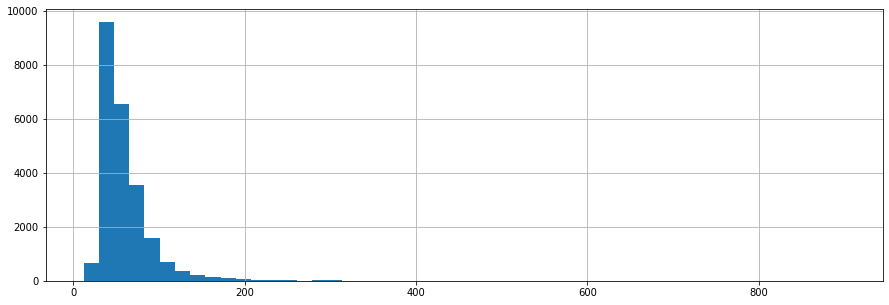

In [98]:
# Общая площадь помещений находится в диапазоне 12...900 м2. Медиана равна 52 м2, среднее порядка 60 м2 - т.о., 
# значение 900 м2 является нетипичным и завышает среднее.

# Цена находится в диапазоне 0.012...763 млн.руб. Разбег гигантский, это видно и по стандартному отклонению - 10.9 млн.руб.
# при значении Q3 равном 6.8 млн.руб. Медиана равна 4.65 млн.руб, среднее порядка 6.5 млн.руб - т.о., значение 763 млн.руб.
# является нетипичным и завышает среднее. Минимальное значение также подозрительное - жилье не может стоить 12 тыс.руб.
# Рассмотрим это значение подробнее на этапе обработки выбросов и артефактов.

# Количество комнат находится в диапазоне 0...19. Значение 0 является подозрительным, возможно, оно соответсвует
# однокомнатной квартире-студии. Медиана равна 2, среднее также порядка 2, соотвественно, разброс значений небольшой, 
# стандартное отклонение порядка 1.

# Высота потолков находится в диапазоне 2.2...4.5 м. Данный диапазон получился после обработки пропусков и выбросов.
# Медиана равна 2.6 м, среднее также порядка 2.7 м, соотвественно, разброс значений небольшой, стандартное отклонение 
# порядка 0.3 м.

# Посмотрим на графики распределения значений по рассматриваемым параметрам.

data['total_area'].hist(bins=50, figsize=(15,5))
plt.show()

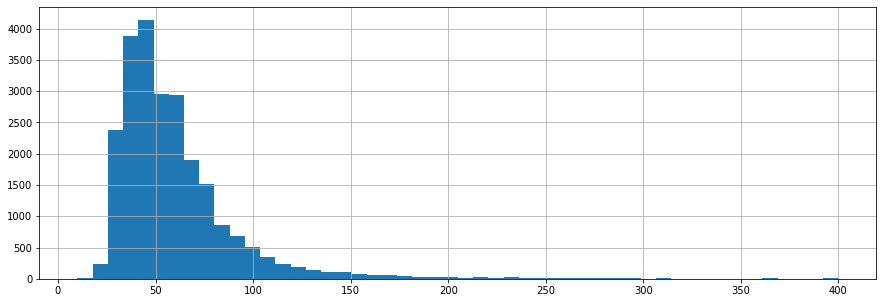

In [99]:
# Для общей площади снизим диапазон отображаемых значений до 400 м2.

data['total_area'].hist(bins=50, range=(10,400), figsize=(15,5))
plt.show()

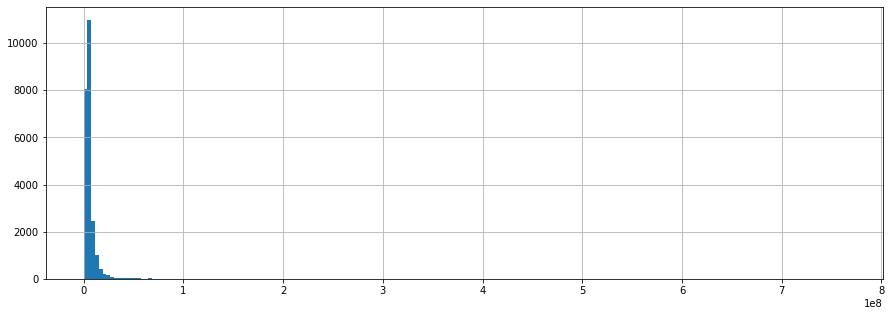

In [100]:
# Распределение напоминает пуассоновское с длинным хвостом. Наибольшее кол-во значений находится в диапазоне 35...50 м2 - 
# хорошая однокомнатная или компактная двухкомнатная квартира. Далее посмотрим на график рапределения цены.

data['last_price'].hist(bins=200, figsize=(15,5))
plt.show()

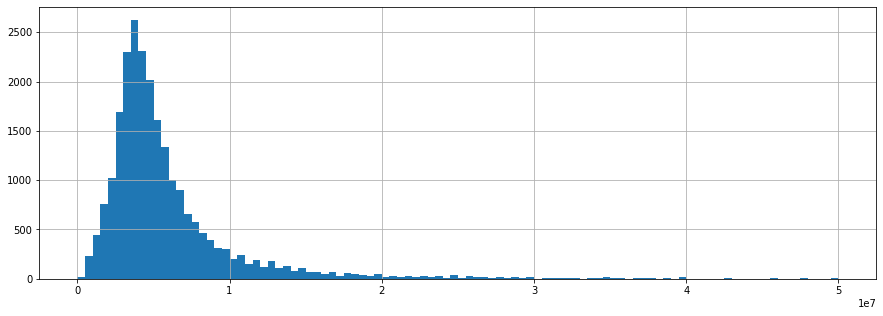

In [101]:
# Для цены снизим диапазон отображаемых значений до 50 млн.руб.

data['last_price'].hist(bins=100, range=(10000,50000000), figsize=(15,5))
plt.show()

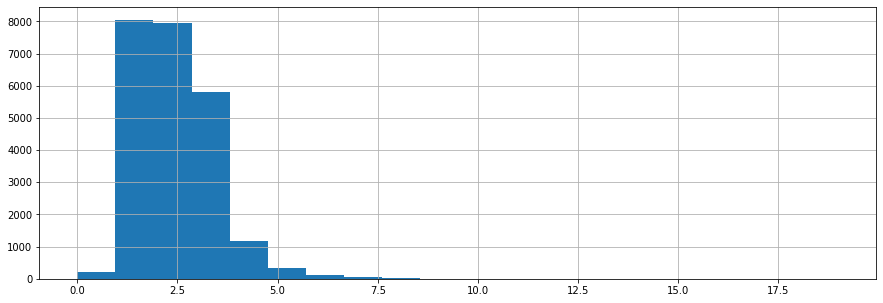

In [102]:
# Распределение также напоминает пуассоновское. Cтоит помнить, что имеются нереально низкие значения цены, которые 
# также оказывают влияние на форму графика. Наибольшее кол-во значений находится в диапазоне 3...5 млн.руб. - для наиболее
# часто встречаемых квартир в объявлениях площадью 35...50 м2 это нормальная цена. Теперь посмотрим на график рапределения 
# количества комнат.

data['rooms'].hist(bins=20, figsize=(15,5))
plt.show()

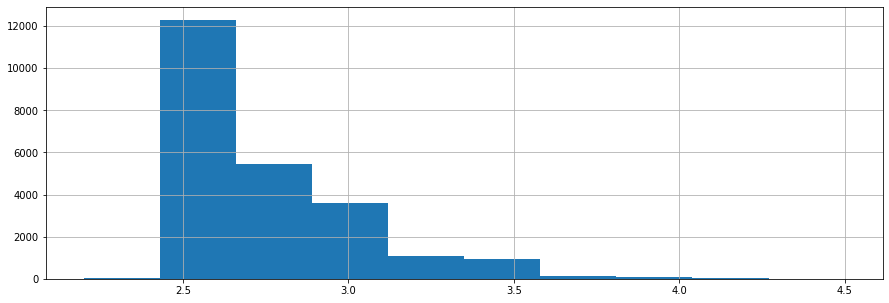

In [103]:
# Распределение опять же напоминает пуассоновское. Вызывает вопрос количество комнат равное 0, с этим разберемся чуть позже.
# Наибольшее кол-во значений находится в диапазоне 1...3 комнаты и это не вызывает вопросов. Посмотрим на графическое 
# распределение последнего параметра - высоты потолков.

data['ceiling_height_consolidation'].hist(bins=10, figsize=(15,5))
plt.show()

In [104]:
# Распределение Пуассона. Выглядит правдоподбно, наибольшая концентрация значений в диапазоне 2.5...2.7 м - стандартная 
# высота потолков в большинстве новостроек и вторичного жилья. Теперь посмотрим на время продажи квартиры и выясним, сколько
# обычно она длится.

data['days_exposition'].describe()

count    23699.000000
mean       185.821722
std        233.380877
min          0.000000
25%         43.000000
50%         94.000000
75%        237.000000
max       1618.000000
Name: days_exposition, dtype: float64

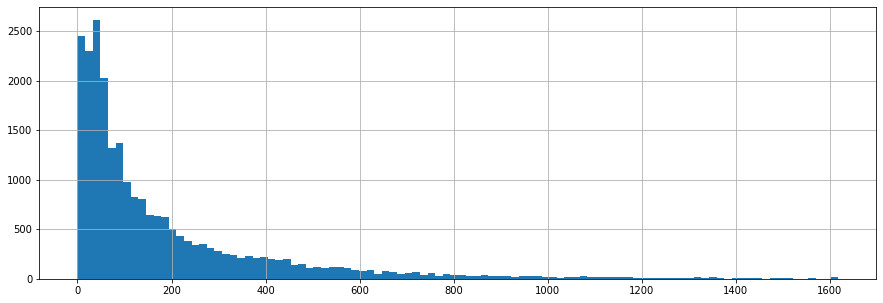

In [105]:
# Вновь большой разброс значений как и в случае с ценой жилья - диапазон 1...1580 дней. Медиана 82, среднее в 2 раза больше
# (165 дней) - оно ближе к третьему квартилю, нежели к медиане. Посмотрим на графическое распределение данного параметра.

data['days_exposition'].hist(bins=100, figsize=(15,5))
plt.show()

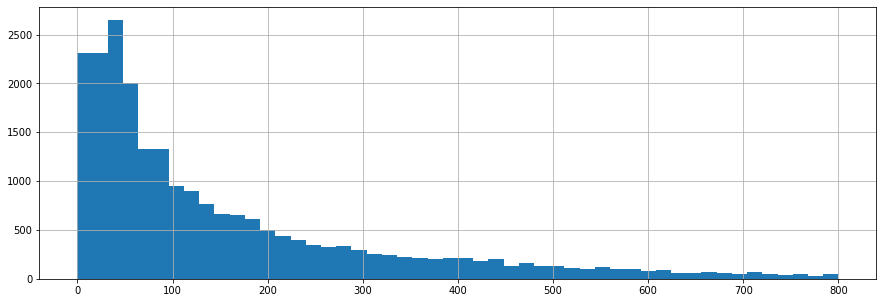

In [106]:
# Вновь вспоминаем Пуассона. Снизим диапазон отображаемых значений до 800 дней.

data['days_exposition'].hist(bins=50, range=(0,800), figsize=(15,5))
plt.show()

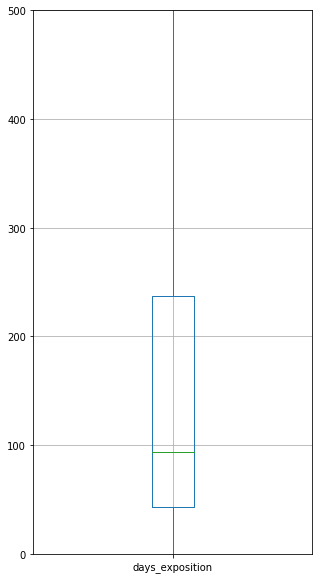

In [107]:
# Наибольшая концентрация значений в диапазоне 0...100 дней. Для более точного определения типичной продолжительности продажи
# построим еще диаграмму размаха.

data.boxplot('days_exposition', figsize=(5,10))
plt.ylim(0,500)
plt.show()

В total_images минимальное значение составляет 0, максимум - 50


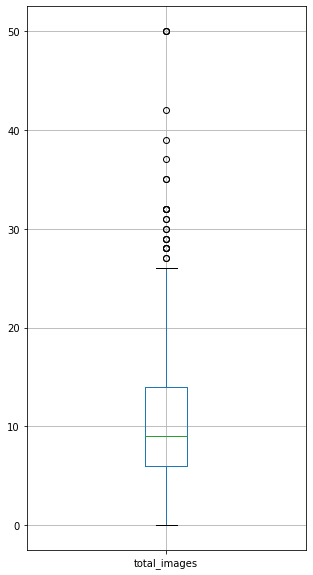

В last_price минимальное значение составляет 12190, максимум - 763000000


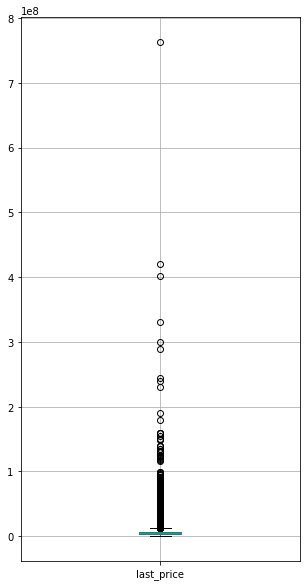

В total_area минимальное значение составляет 12.0, максимум - 900.0


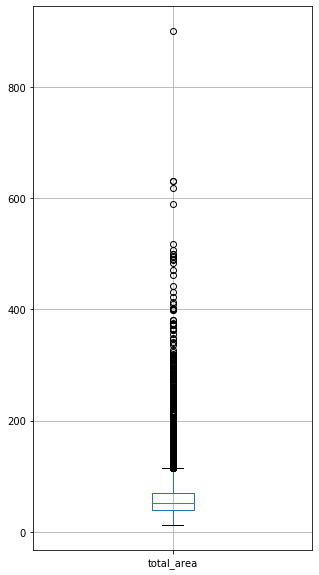

В rooms минимальное значение составляет 0, максимум - 19


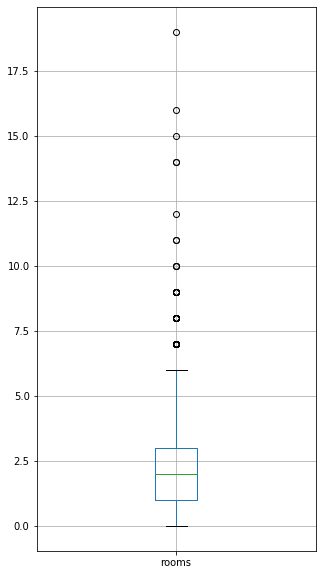

В ceiling_height минимальное значение составляет 2.2, максимум - 4.5


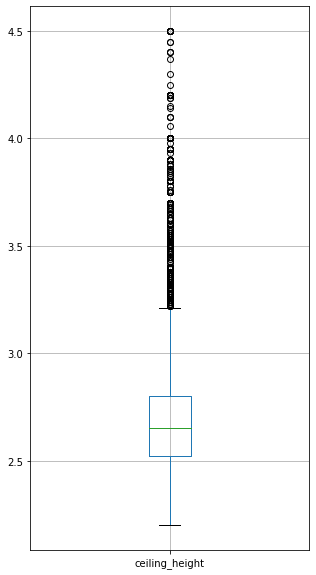

В floors_total минимальное значение составляет 1, максимум - 60


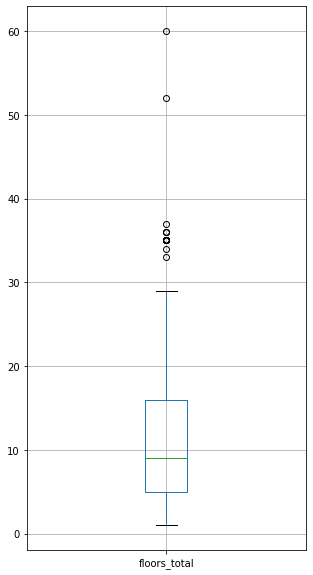

В living_area минимальное значение составляет 2.0, максимум - 409.7


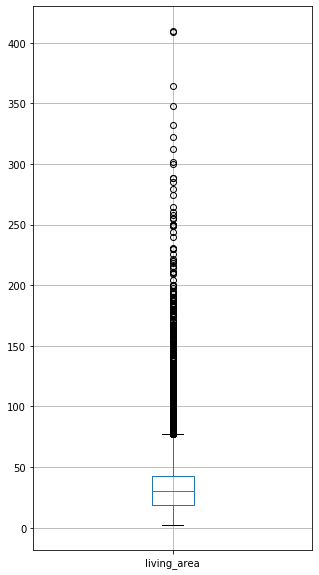

В floor минимальное значение составляет 1, максимум - 33


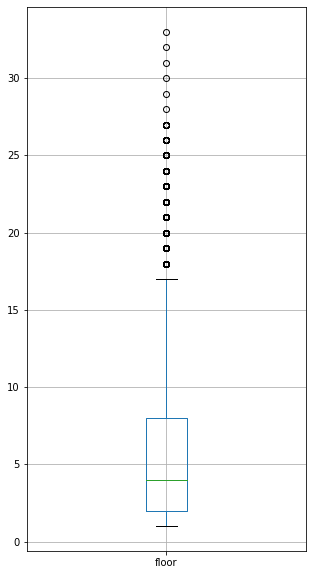

В kitchen_area минимальное значение составляет 0.0, максимум - 112.0


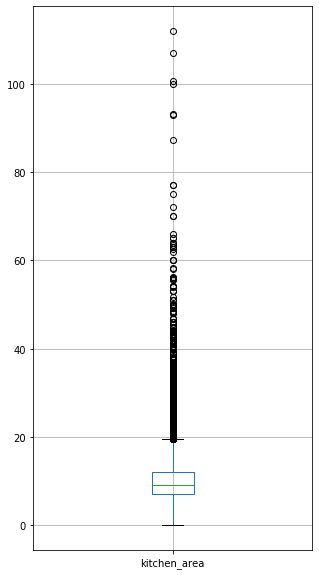

В balcony минимальное значение составляет 0, максимум - 5


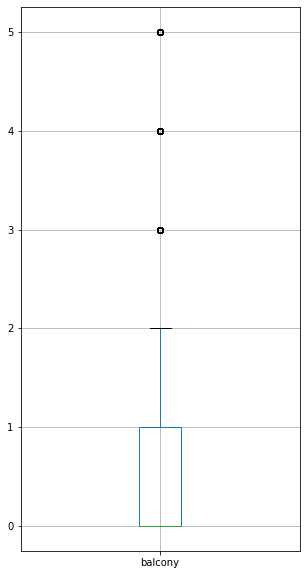

В airports_nearest минимальное значение составляет 0.0, максимум - 84869.0


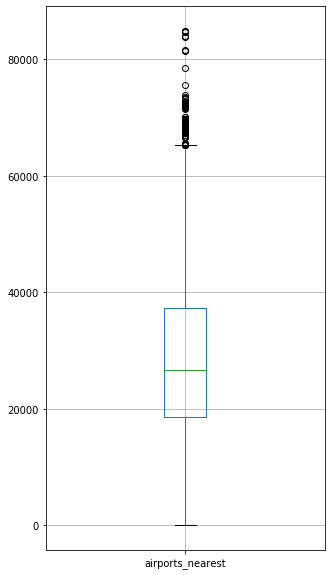

В cityCenters_nearest минимальное значение составляет 181.0, максимум - 65968.0


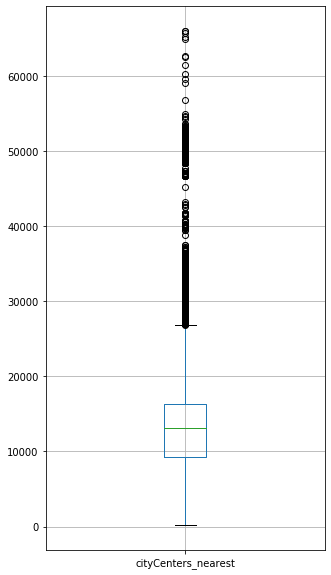

В parks_around3000 минимальное значение составляет 0.0, максимум - 3.0


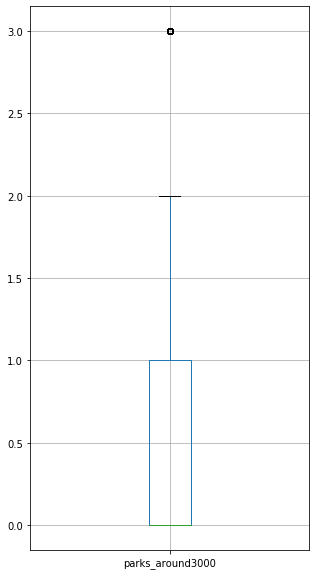

В parks_nearest минимальное значение составляет 1.0, максимум - 3190.0


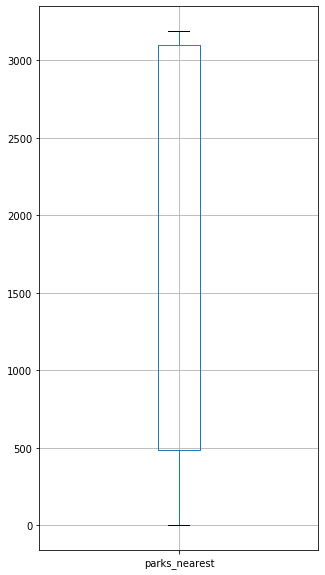

В ponds_around3000 минимальное значение составляет 0.0, максимум - 3.0


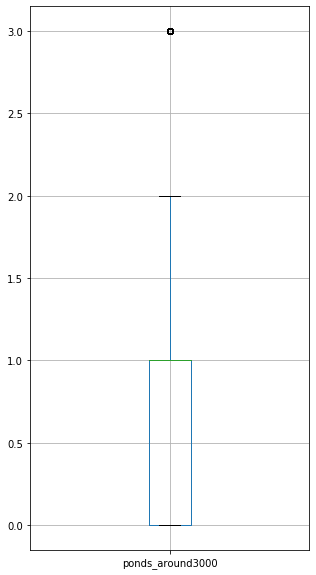

В ponds_nearest минимальное значение составляет 13.0, максимум - 3100.0


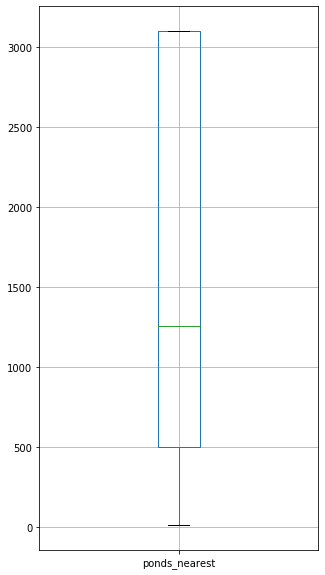

В days_exposition минимальное значение составляет 0, максимум - 1618


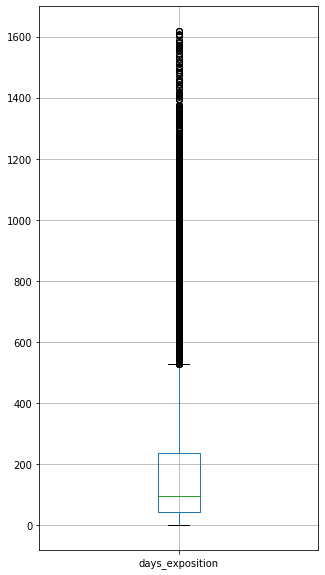

В ceiling_height_consolidation минимальное значение составляет 2.2, максимум - 4.5


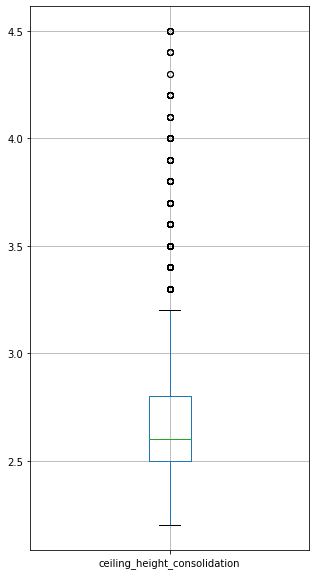

В sq_meter_price минимальное значение составляет 111, максимум - 1907500


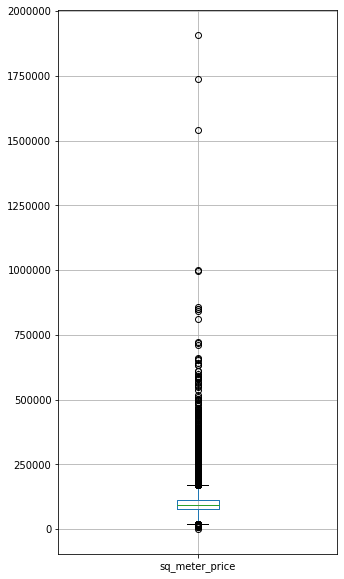

В exposition_weekday минимальное значение составляет 0, максимум - 6


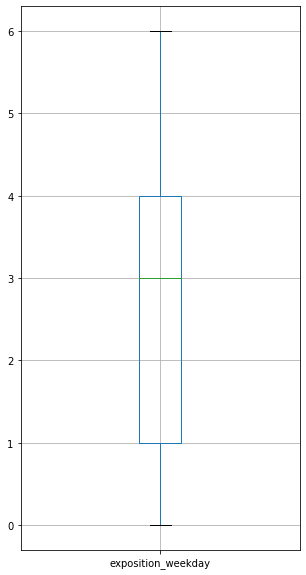

В exposition_month минимальное значение составляет 1, максимум - 12


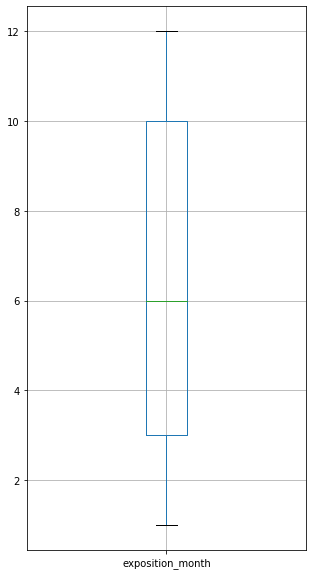

В exposition_year минимальное значение составляет 2014, максимум - 2019


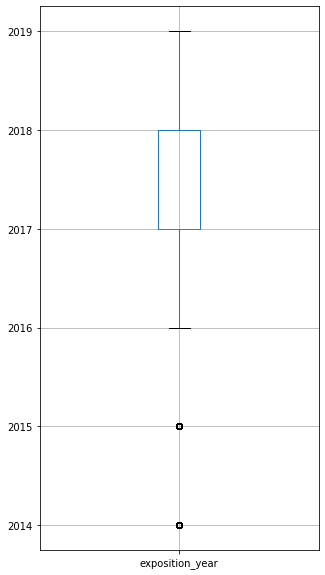

В living_total_ratio минимальное значение составляет 0.02158273381294964, максимум - 1.0


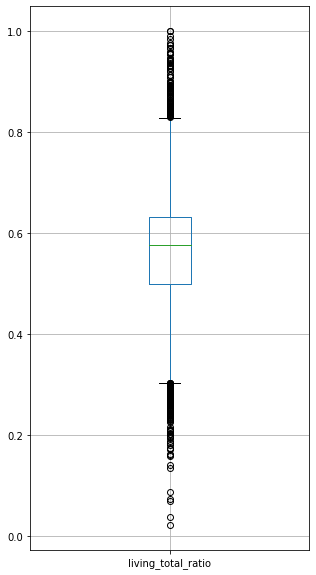

В kitchen_total_ratio минимальное значение составляет 0.0, максимум - 0.7878787878787878


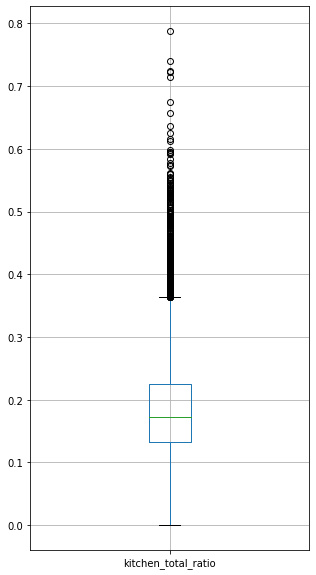

In [108]:
# По диаграмме видно, что медиана гораздо ближе к первому квартилю, чем к третьему. Это говорит о наличии большого
# количества значений за пределами максимума нормального расперделения. Т.о., продажа квартиры обычно занимает от одного до
# семи месяцев. Продажу квартиры можно считать необычно быстрой, если она заняла менее недели, необычно долгой - более 
# полутора лет.

# Теперь вернемся к проверке датасета на наличие выбросов и артефактов и последующей очистке от них. Построим для каждого 
# числового признака диаграмму размаха.

for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        print('В {} минимальное значение составляет {}, максимум - {}'.format(column, data[column].min(), data[column].max()))
        data.boxplot(column, figsize=(5,10))
        plt.show()
    else: pass

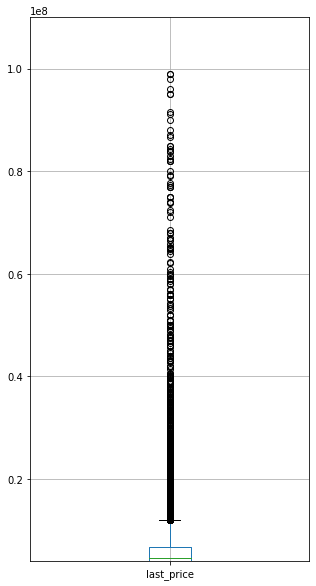

In [109]:
# В количестве фотографий жилья выбросы и артефакты искать не стоит, диапазон значений 0...50.

# В стоимости жилья значения выше 100 млн.руб можно смело убирать. Для проверки минимума нужно приблизить зону нормального
# распределения.

data.boxplot('last_price', figsize=(5,10))
plt.ylim(4000000, 110000000)
plt.show()

In [110]:
# По диаграмме видно, что максимум можно снизить и до 90 млн.руб. Посмотрим на количество значений, которого мы лишимся при
# лимитировании верхней границы датасета.

print(data.query('last_price > 90000000')['last_price'].count(),
      (data.query('last_price > 90000000')['last_price'].count() * 100 / data['last_price'].count()).round(2), 
      sep='\n'
     )

45
0.19


In [111]:
# 45 наблюдений или 0.19% от всего датасета. Ради повышения качества анализа этим можно пожертвовать. Создадим новый 
# датасет, из которого уберем выбросы и артефакты.

data_filtered = data.query('last_price <= 90000000')

In [112]:
# Более детально посмотрим на минимальные значения в стоимости жилья, т.к. они входят в зону нормального распределения 
# по диаграмме размаха.

data_filtered.sort_values(by='last_price')[['last_price', 'total_area', 'locality_name', 'sq_meter_price']].head(20)

,last_price,total_area,locality_name,sq_meter_price
8793,12190,109.0,санкт-петербург,111
17456,430000,30.4,сланцы,14144
14911,430000,54.0,посёлок станции свирь,7962
16274,440000,40.0,деревня старополье,11000
16219,450000,38.5,деревня вахнова кара,11688
17676,450000,36.5,деревня ям-тесово,12328
9581,450000,43.4,деревня старополье,10368
5698,450000,42.0,городской посёлок будогощь,10714
21912,470000,37.0,поселок совхозный,12702
18867,470000,41.0,деревня выскатка,11463


In [113]:
# Вот и выяснили. Цена 12190 руб. указана ошибочно - вероятно у нее отвалились последние три нуля. Посмотрим на среднюю 
# стоимость квартир в Питере с аналогичной площадью.

data_filtered.query('total_area == 109')['last_price'].median()

13350000.0

In [114]:
# Бинго! Меняем цену на 12 190 000 руб. и идем дальше.

data_filtered.loc[8793, 'last_price'] = 12190000

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


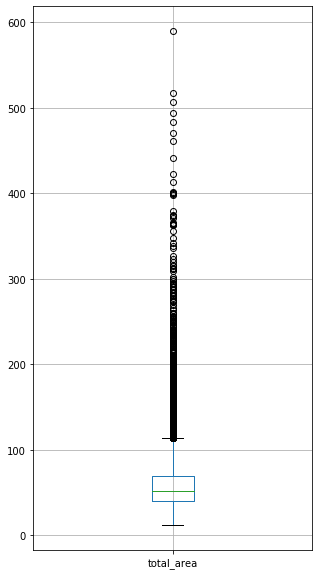

In [115]:
# Построим диаграмму размаха по площади жилья для нового датасета.

data_filtered.boxplot('total_area', figsize=(5,10))
plt.show()

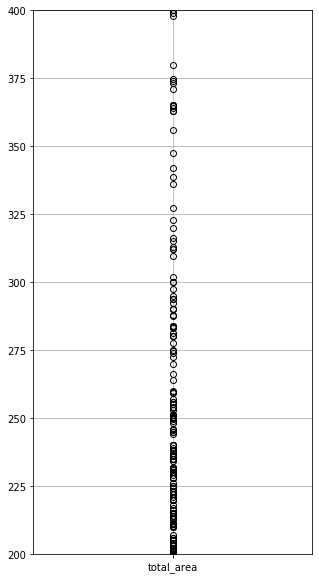

In [116]:
# Значения больше 400 м2 можно смело убирать. Немного приблизим интересующий участок диаграммы.

data_filtered.boxplot('total_area', figsize=(5,10))
plt.ylim(200, 400)
plt.show()

In [117]:
# Посмотрим на количество значений, которого мы лишимся при лимитировании верхней границы датасета в 300 м2.

print(data_filtered.query('total_area > 300')['total_area'].count(),
      (data_filtered.query('total_area > 300')['total_area'].count() * 100 / data_filtered['total_area'].count()).round(2), 
      sep='\n'
     )

41
0.17


In [118]:
# Пожертвуем 41 наблюдением.

data_filtered = data_filtered.query('total_area <= 300')

In [119]:
# Посмотрим на минимальные значения в площадях.

data_filtered.sort_values(by='total_area')[['last_price', 'total_area', 'locality_name', 'sq_meter_price']].head(20)

,last_price,total_area,locality_name,sq_meter_price
19904,2400000,12.00,санкт-петербург,200000
17961,1400000,13.00,санкт-петербург,107692
19807,3800000,13.00,санкт-петербург,292307
19546,1850000,13.00,санкт-петербург,142307
19558,1686000,13.20,санкт-петербург,127727
19642,1190000,14.00,санкт-петербург,85000
16949,1550000,15.00,санкт-петербург,103333
12040,1900000,15.00,сосновый бор,126666
8886,2450000,15.50,санкт-петербург,158064
9412,2100000,16.00,санкт-петербург,131250


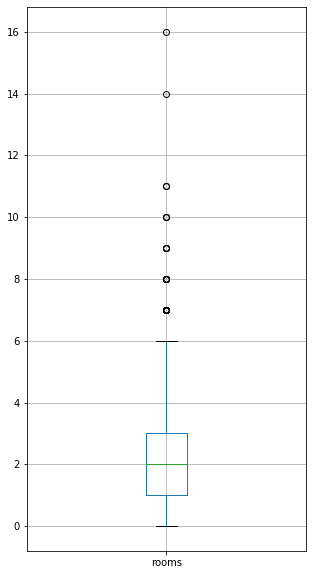

In [120]:
# Нереальные значения отсутствуют. Переходим к количеству комнат.

data_filtered.boxplot('rooms', figsize=(5,10))
plt.show()

In [121]:
# Посмотрим на количество значений, которого мы лишимся при лимитировании верхней границы датасета в 6 комнат.

print(data_filtered.query('rooms > 6')['total_area'].count(),
      (data_filtered.query('rooms > 6')['total_area'].count() * 100 / data_filtered['rooms'].count()).round(2), 
      sep='\n'
     )

61
0.26


In [122]:
# А если ограничиться 7 комнатами?

print(data_filtered.query('rooms > 7')['total_area'].count(),
      (data_filtered.query('rooms > 7')['total_area'].count() * 100 / data_filtered['rooms'].count()).round(2), 
      sep='\n'
     )

18
0.08


In [123]:
# Отлично, убираем наблюдения с более чем 7 комнатами.

data_filtered = data_filtered.query('rooms <= 7')

In [124]:
# Проверим наблюдения с 0 комнат и предположение, что данные значения характерны для квартир-студий.

data_filtered.query('rooms == 0')['studio'].value_counts()

True     138
False     58
Name: studio, dtype: int64

In [125]:
# Отлично. Остальные 58 жилищ с 0 комнат должны относиться к квартирам с открытой планировкой.

data_filtered.query('rooms == 0')['open_plan'].value_counts()

False    138
True      58
Name: open_plan, dtype: int64

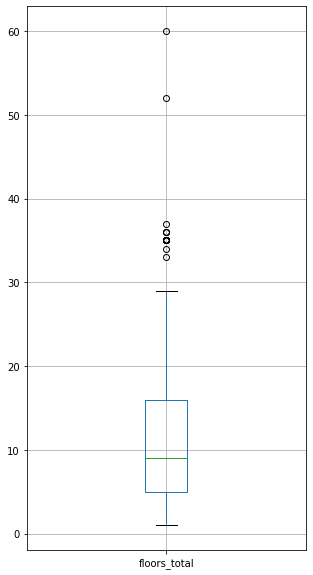

In [126]:
# Так и есть. Теперь посмотрим на диаграмму размаха по этажности зданий.

data_filtered.boxplot('floors_total', figsize=(5,10))
plt.show()

In [127]:
# Посмотрим на количество значений, которого мы лишимся при лимитировании верхней границы датасета в 30 этажей.

print(data_filtered.query('floors_total > 30')['total_area'].count(),
      (data_filtered.query('floors_total > 30')['total_area'].count() * 100 / data_filtered['floors_total'].count()).round(2), 
      sep='\n'
     )

32
0.14


In [128]:
# А если ограничиться 40 этажными зданиями, такие же бывают?

print(data_filtered.query('floors_total > 40')['total_area'].count(),
      (data_filtered.query('floors_total > 40')['total_area'].count() * 100 / data_filtered['floors_total'].count()).round(2), 
      sep='\n'
     )

2
0.01


In [129]:
# Есть решение.

data_filtered = data_filtered.query('floors_total <= 40')

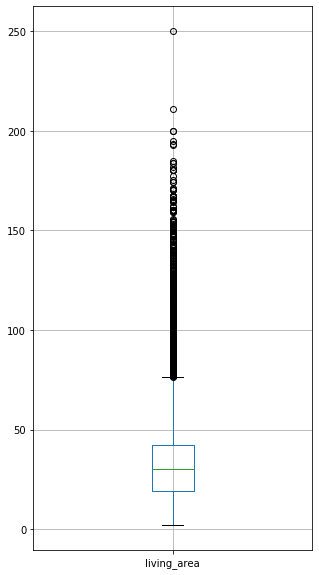

In [130]:
# Проверим распределение наблюдения по жилой площади.

data_filtered.boxplot('living_area', figsize=(5,10))
plt.show()

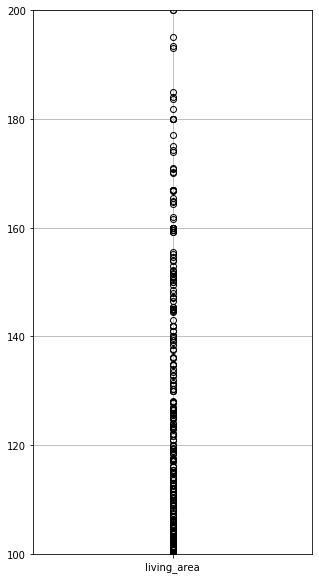

In [131]:
# Значения больше 160 м2 можно убирать. Чуть приблизим диаграмму.

data_filtered.boxplot('living_area', figsize=(5,10))
plt.ylim(100, 200)
plt.show()

In [132]:
# Посмотрим на количество значений, которого мы лишимся при лимитировании верхней границы датасета.

print(data_filtered.query('living_area > 160')['total_area'].count(),
      (data_filtered.query('living_area > 160')['total_area'].count() * 100 / data_filtered['living_area'].count()).round(2), 
      sep='\n'
     )

34
0.14


In [133]:
# Отлично, ограничимся 160 м2.

data_filtered = data_filtered.query('living_area <= 160')

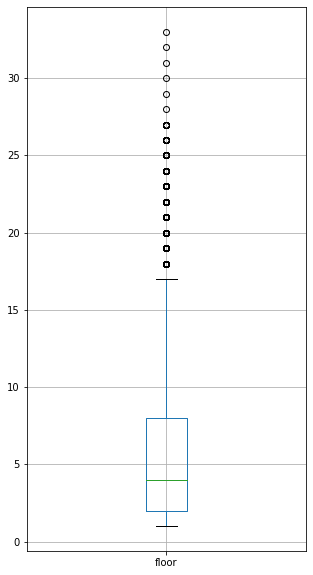

In [134]:
# Построим диаграмму размаха для этажа, на котором расположено жилье.

data_filtered.boxplot('floor', figsize=(5,10))
plt.show()

In [135]:
# Посмотрим на количество значений, которого мы лишимся при лимитировании верхней границы датасета в 30 этажей.

print(data_filtered.query('floor > 30')['total_area'].count(),
      (data_filtered.query('floor > 30')['total_area'].count() * 100 / data_filtered['floor'].count()).round(2), 
      sep='\n'
     )

3
0.01


In [136]:
# Наглядное представление. Убираем наблюдения с расположением жилья выше 30 этажа.

data_filtered = data_filtered.query('floor <= 30')

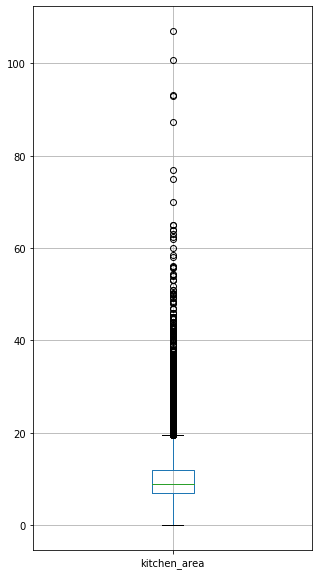

In [137]:
# Далее смотрим площадь кухни.

data_filtered.boxplot('kitchen_area', figsize=(5,10))
plt.show()

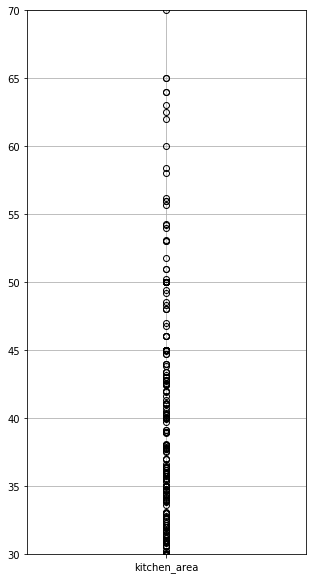

In [138]:
# Значения больше 60 м2 можно убирать. Приблизим диаграмму.

data_filtered.boxplot('kitchen_area', figsize=(5,10))
plt.ylim(30, 70)
plt.show()

In [139]:
# Проверим количество значений, которого мы лишимся при лимитировании верхней границы датасета в 60 м2.

print(data_filtered.query('kitchen_area > 60')['total_area'].count(),
      (data_filtered.query('kitchen_area > 60')['total_area'].count() * 100 / data_filtered['kitchen_area'].count()).round(2), 
      sep='\n'
     )

15
0.06


In [140]:
# Ограничимся 60 м2.

data_filtered = data_filtered.query('kitchen_area <= 60')

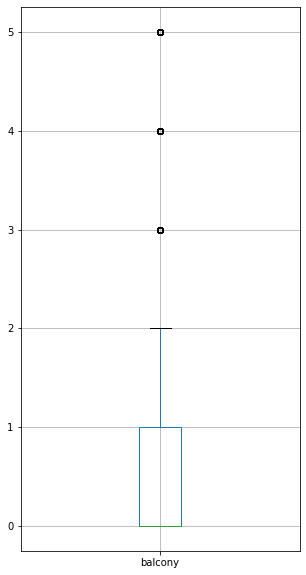

In [141]:
# Проверим распределение по кол-ву балконов.

data_filtered.boxplot('balcony', figsize=(5,10))
plt.show()

In [142]:
# Проверим количество значений, которого мы лишимся при лимитировании верхней границы датасета в 2 балкона.

print(data_filtered.query('balcony > 2')['total_area'].count(),
      (data_filtered.query('balcony > 2')['total_area'].count() * 100 / data_filtered['balcony'].count()).round(2), 
      sep='\n'
     )

562
2.39


In [143]:
# Много. Проверим количество наблюдений с 5ю балконами.

print(data_filtered.query('balcony == 5')['total_area'].count(),
      (data_filtered.query('balcony == 5')['total_area'].count() * 100 / data_filtered['balcony'].count()).round(2), 
      sep='\n'
     )

302
1.28


In [144]:
# Все наглядно, 1.3% данных терять не хочется да и не зачем. Что у нас с расстояниями до аэропорта?

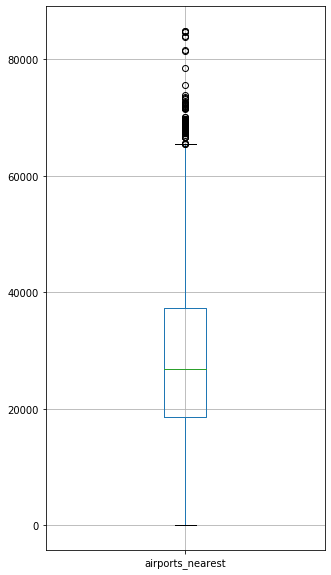

In [145]:
data_filtered.boxplot('airports_nearest', figsize=(5,10))
plt.show()

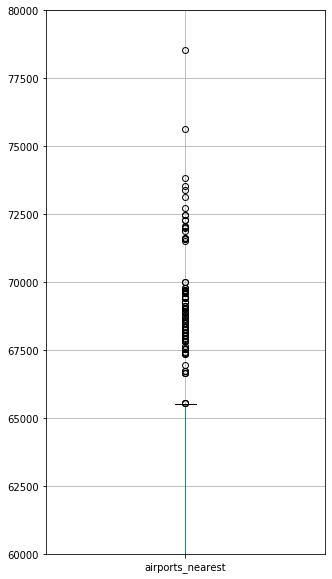

In [146]:
# Приблизим диаграмму.

data_filtered.boxplot('airports_nearest', figsize=(5,10))
plt.ylim(60000, 80000)
plt.show()

In [147]:
# Проверим количество значений, которого мы лишимся при лимитировании верхней границы датасета в 75 км.

print(data_filtered.query('airports_nearest > 75000')['total_area'].count(),
      (data_filtered.query('airports_nearest > 75000')['total_area'].count() * 100 / data_filtered['airports_nearest'].count()).round(2), 
      sep='\n'
     )

9
0.05


In [148]:
# Отлично.

data_filtered = data_filtered.query('airports_nearest <= 75000 | airports_nearest =="NaN"')

In [149]:
# Посмотрим на минимальные значения данного параметра.

data_filtered.sort_values(by='airports_nearest')['airports_nearest'].head(20)

21085       0.0
4017     6450.0
12899    6450.0
7778     6914.0
23150    6949.0
10059    6989.0
11294    6989.0
5074     6989.0
22283    6989.0
5062     6989.0
15633    6989.0
10986    6992.0
16576    6995.0
895      6995.0
15336    7002.0
4186     7016.0
11245    7016.0
17704    7016.0
20692    7016.0
1030     7019.0
Name: airports_nearest, dtype: float64

In [150]:
# Одна квартира находится в аэропорту? Проверим.

data_filtered.query('airports_nearest == 0')[['cityCenters_nearest', 'locality_name']]

,cityCenters_nearest,locality_name
21085,22801.0,санкт-петербург


In [151]:
# Находится в Питере, до центра примерно 23 км. Посмотрим, может есть объявления на продажу квартир в этом доме.

data_filtered.query('cityCenters_nearest == 22801')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,ceiling_height_consolidation,many_nan,sq_meter_price,exposition_weekday,exposition_month,exposition_year,housing_location,living_total_ratio,kitchen_total_ratio
21085,0,7000000,34.7,2018-09-23,1,2.7,9,19.8,3,False,...,60,2.7,False,201729,6,9,2018,другой этаж,0.570605,0.172911


In [152]:
# Одно наблюдение. Заменим 0 на NaN.

data_filtered.loc[21085, 'airports_nearest'] = math.nan

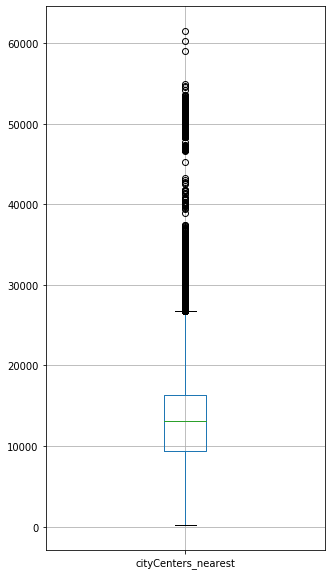

In [153]:
# Поглядим на расстояния до центра.

data_filtered.boxplot('cityCenters_nearest', figsize=(5,10))
plt.show()

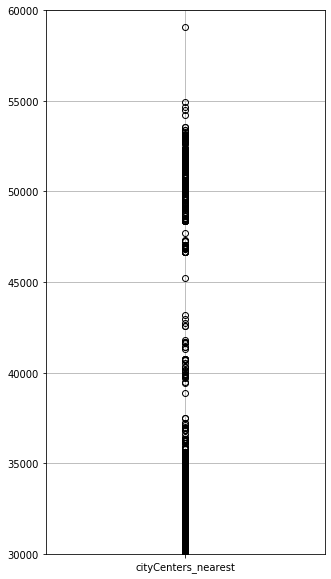

In [154]:
# Неоднородное распределение. Это можно объяснить присутствием в датасете большого кол-ва населенных пунктов и расположением
# центра, до которого измеряется расстояние, в центре Питера. Приблизим диаграмму.

data_filtered.boxplot('cityCenters_nearest', figsize=(5,10))
plt.ylim(30000, 60000)
plt.show()

In [155]:
# Проверим количество значений, которого мы лишимся при лимитировании верхней границы датасета в 55 км.

print(data_filtered.query('cityCenters_nearest > 55000')['total_area'].count(),
      (data_filtered.query('cityCenters_nearest > 55000')['total_area'].count() * 100 / data_filtered['cityCenters_nearest'].count()).round(2), 
      sep='\n'
     )

3
0.02


In [156]:
# Идем дальше.

data_filtered = data_filtered.query('cityCenters_nearest <= 55000 | cityCenters_nearest == "NaN"')

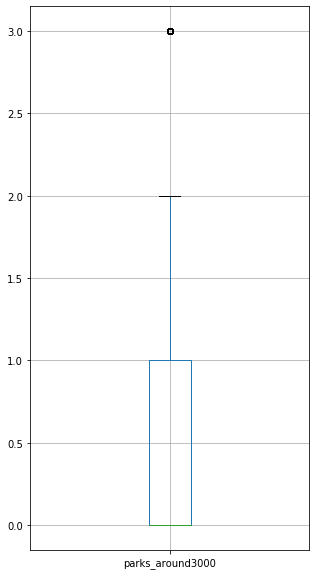

In [157]:
# Смотрим количество парков в радиусе 3 км.

data_filtered.boxplot('parks_around3000', figsize=(5,10))
plt.show()

In [158]:
# В большинстве случаев парки расположены дальше, чем в 3 км. Проверим количество значений, которого мы лишимся при 
# лимитировании верхней границы датасета в 2 парка.

print(data_filtered.query('parks_around3000 > 2')['total_area'].count(),
      (data_filtered.query('parks_around3000 > 2')['total_area'].count() * 100 / data_filtered['parks_around3000'].count()).round(2), 
      sep='\n'
     )

613
3.4


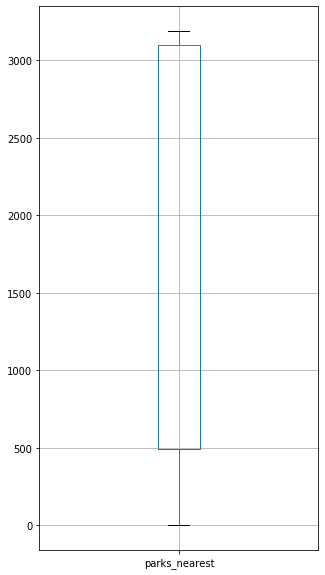

In [159]:
# Много. Оставляем без изменений. Пройдемся по расстояниям до ближайших парков.

data_filtered.boxplot('parks_nearest', figsize=(5,10))
plt.show()

In [160]:
# Верхнее значение получилось благодаря замене пропусков на значение 3100 м. Посмотрим на минимальные значения.

data_filtered.sort_values(by='parks_nearest')['parks_nearest'].head(20)

14624     1.0
11949     3.0
22941     4.0
9344      7.0
20193     9.0
2527      9.0
4470     10.0
214      10.0
19093    10.0
189      10.0
21773    10.0
15296    10.0
7788     10.0
16831    11.0
12018    11.0
1214     11.0
21167    11.0
19215    11.0
14015    12.0
17709    13.0
Name: parks_nearest, dtype: float64

In [161]:
# Расстояние в 1 м. Проверим.

data_filtered.query('parks_nearest < 10')[['parks_nearest', 'parks_around3000', 'cityCenters_nearest', 'locality_name', 'floors_total']]

,parks_nearest,parks_around3000,cityCenters_nearest,locality_name,floors_total
2527,9.0,3.0,51500.0,кронштадт,5
9344,7.0,1.0,11665.0,санкт-петербург,9
11949,3.0,1.0,12292.0,санкт-петербург,9
14624,1.0,1.0,16436.0,санкт-петербург,9
20193,9.0,2.0,6410.0,санкт-петербург,9
22941,4.0,3.0,54490.0,зеленогорск,4


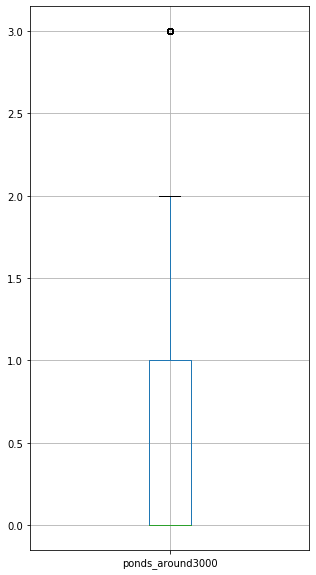

In [162]:
# Противоречия с количеством парков в радиусе 3 км нет. Видимо в таких наблюдениях парк находится во дворе. Посмотрим на
# количество водоемов в радиусе 3 км.

data_filtered.boxplot('ponds_around3000', figsize=(5,10))
plt.show()

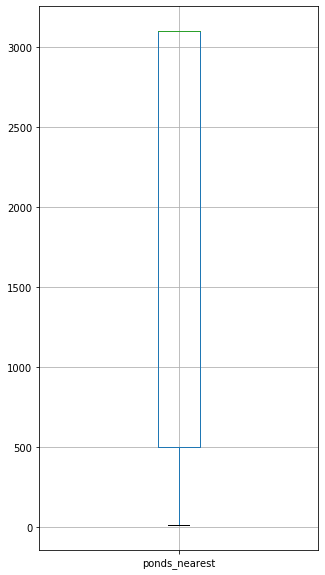

In [163]:
# Аналогичная ситуация, что и с парками. Оставляем без изменений. Проверим расстояние до ближайших водоемов.

data_filtered.boxplot('ponds_nearest', figsize=(5,10))
plt.show()

In [164]:
# Снова тоже, что и у парков. Проверим минимальное значение.

data_filtered['ponds_nearest'].min()

13.0

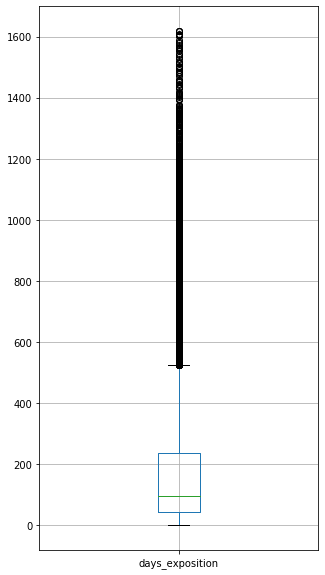

In [165]:
# Хорошее значение, идем дальше к количеству дней размещения публикации.

data_filtered.boxplot('days_exposition', figsize=(5,10))
plt.show()

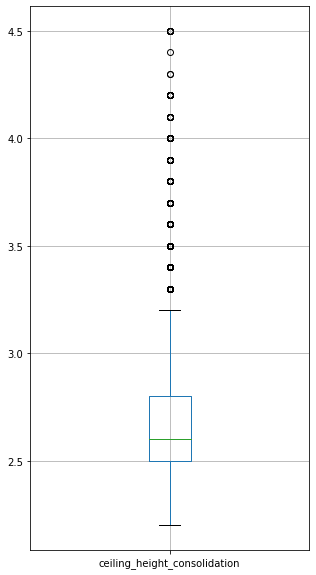

In [166]:
# В данном показателе убирать ничего не нужно, т.к. по нему будет определяться продаваемость жилья. Посмотрим на 
# распределение по высоте потолков.

data_filtered.boxplot('ceiling_height_consolidation', figsize=(5,10))
plt.show()

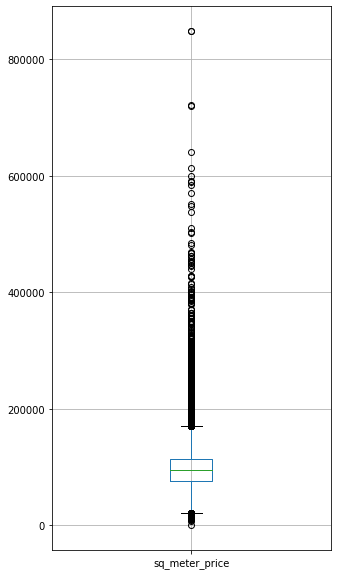

In [167]:
# Диапазон значений в данном показателе основан на ранее выполненном заполнении пропусков. Оставляем без изменений. Проверяем
# цены за квадратный метр.

data_filtered.boxplot('sq_meter_price', figsize=(5,10))
plt.show()

In [168]:
# Ограничимся 400 тыс.руб/м2. Проверим количество значений, которого мы лишимся при лимитировании верхней границы датасета.

print(data_filtered.query('sq_meter_price > 400000')['total_area'].count(),
      (data_filtered.query('sq_meter_price > 400000')['total_area'].count() * 100 / data_filtered['sq_meter_price'].count()).round(2), 
      sep='\n'
     )

41
0.17


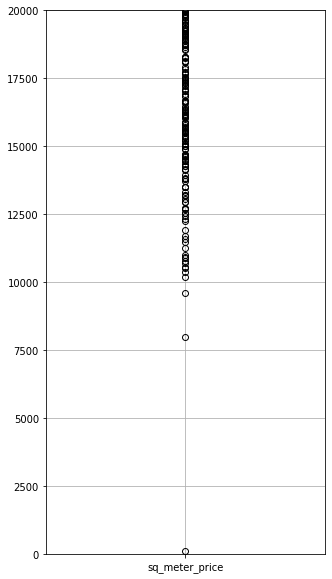

In [169]:
# Дорогой квадрат. Но ничего не поделаешь - 400 так 400. Минимальные значения также нужно убрать.

data_filtered = data_filtered.query('sq_meter_price <= 400000')

data_filtered.boxplot('sq_meter_price', figsize=(5,10))
plt.ylim(0, 20000)
plt.show()

In [170]:
# Убираем наблюдения с ценами ниже 10 тыс.руб.

data_filtered = data_filtered.query('sq_meter_price >= 10000')

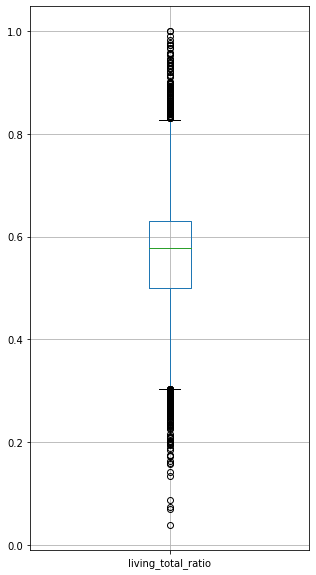

In [171]:
# Осталось проверить показатели 'living_total_ratio' и 'kitchen_total_ratio' на наличие выбросов и артефактов.

data_filtered.boxplot('living_total_ratio', figsize=(5,10))
plt.show()

In [172]:
# В 'living_total_ratio' можно ограничиться диапазоном 0.2...0.95. Проверим количество значений, которое будет отфильтровано.

print(data_filtered.query('living_total_ratio > 0.95 | living_total_ratio < 0.2')['total_area'].count(),
      (data_filtered.query('living_total_ratio > 0.95 | living_total_ratio < 0.2')['total_area'].count() * 100 / data_filtered['living_total_ratio'].count()).round(2), 
      sep='\n'
     )

31
0.13


In [173]:
# Убираем явные выбросы.

data_filtered = data_filtered.query('living_total_ratio <= 0.95 | living_total_ratio >= 0.2')

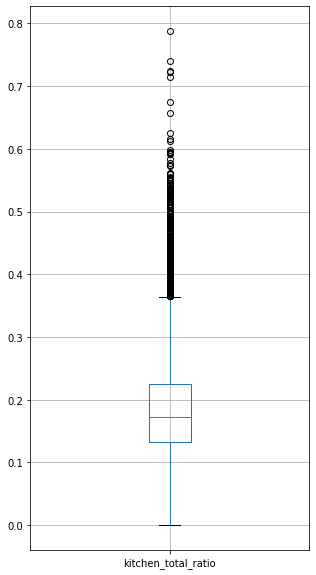

In [174]:
# Проверяем 'kitchen_total_ratio'.

data_filtered.boxplot('kitchen_total_ratio', figsize=(5,10))
plt.show()

In [175]:
# Можно убрать строки со значением более 0.6. Смотрим количество потерь.

print(data_filtered.query('kitchen_total_ratio > 0.6')['total_area'].count(),
      (data_filtered.query('kitchen_total_ratio > 0.6')['total_area'].count() * 100 / data_filtered['kitchen_total_ratio'].count()).round(2), 
      sep='\n'
     )

10
0.04


In [176]:
# Убираем.

data_filtered = data_filtered.query('kitchen_total_ratio <= 0.6')

In [177]:
# Посмотрим, насколько сократился исходный датасет.

print('Исходный датасет за счет удаления явных выбросов уменьшился на {:%}'.format(1-len(data_filtered.index)/len(data.index)))

Исходный датасет за счет удаления явных выбросов уменьшился на 0.945188%


Корреляция Пирсона между стоимостью жилья и total_area составляет 77.84%


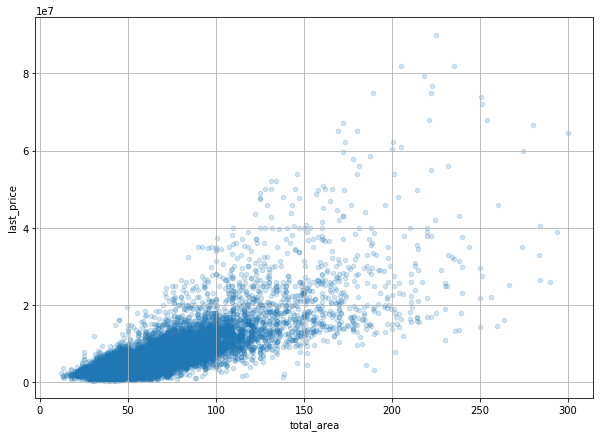

Корреляция Пирсона между стоимостью жилья и living_area составляет 68.33%


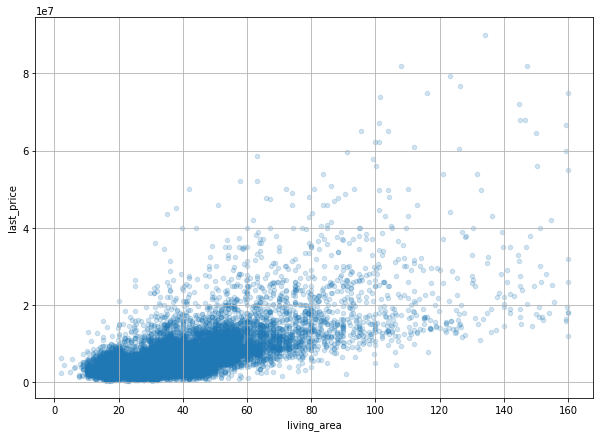

Корреляция Пирсона между стоимостью жилья и kitchen_area составляет 60.01%


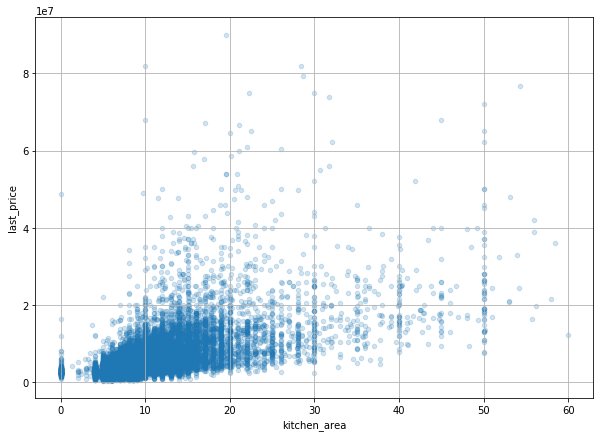

Корреляция Пирсона между стоимостью жилья и rooms составляет 48.09%


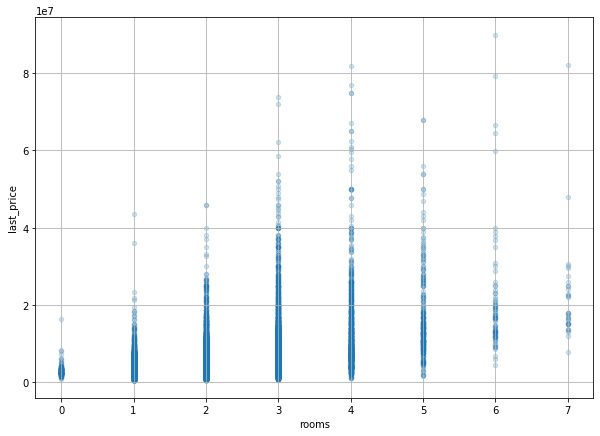

Корреляция Пирсона между стоимостью жилья и cityCenters_nearest составляет -31.91%


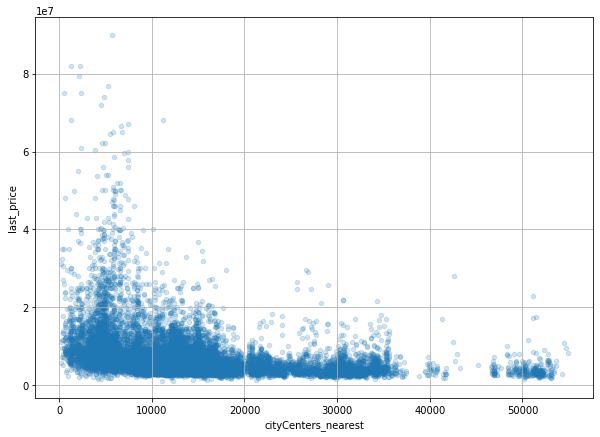

Корреляция Пирсона между стоимостью жилья и exposition_weekday составляет -1.19%


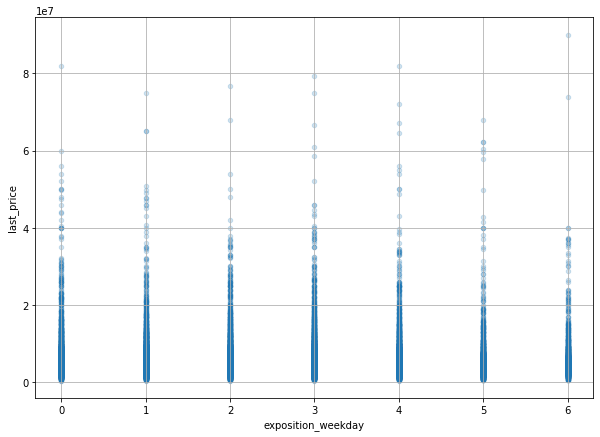

Корреляция Пирсона между стоимостью жилья и exposition_month составляет 0.16%


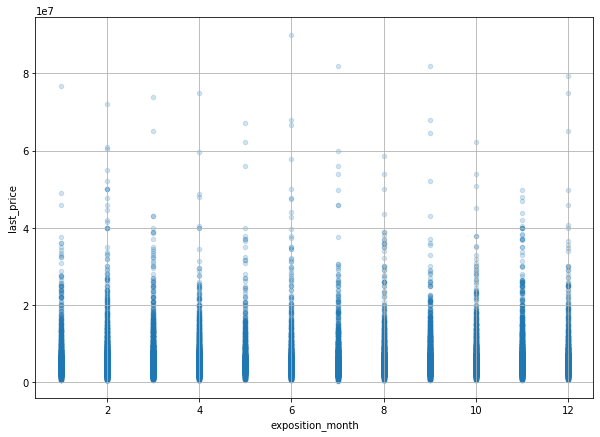

Корреляция Пирсона между стоимостью жилья и exposition_year составляет -5.26%


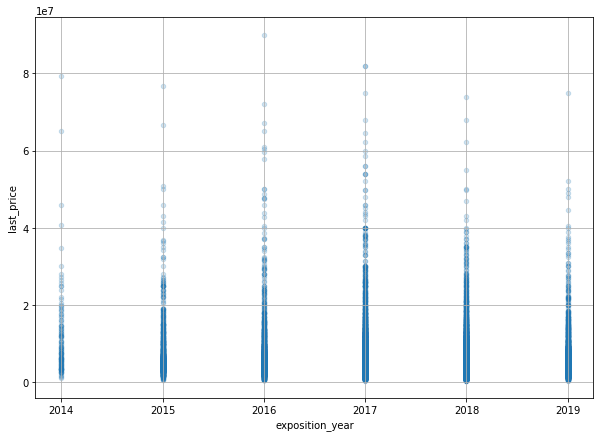

In [220]:
# Менее 1%. Переходим к определению факторов, оказывающих наибольшее влияние на стоимость жилья. Рассмотрим следующие -
# количество квадратных метров (общая площадь, жилая и кухонная), число комнат, удаленность от центра, этаж расположения 
# жилья (варианты: первый, другой и последний), дата размещения публикации (день недели, месяц, год).

evaluated_factors = ['total_area', 'living_area', 'kitchen_area', 
                     'rooms', 'cityCenters_nearest',
                     'exposition_weekday', 'exposition_month', 'exposition_year'
                     ]

for factor in evaluated_factors:

    print('Корреляция Пирсона между стоимостью жилья и {} составляет {:.2%}'.format(factor, data_filtered[factor].corr(data_filtered['last_price'])))
    data_filtered.plot(x=factor, y='last_price', kind='scatter', alpha=0.2, grid=True, figsize=(10,7))
    plt.show()

Смотрим на результаты:

- наибольшая корреляция цены жилья с её общей площадью (77.8%);
- с жилой и кухонной площадями корреляция средняя - 68.3 и 60.0% соответственно;
- зависимость с количеством комнат слабая и составляет 48.1%;
- удаленность от центра также не является определяющим фактором в ценообразовании жилья - корреляция минус 31.9%;
- от времени размещения объявления о продаже жилья его стоимость никак не зависит.

In [181]:
# Проверим наличие зависимости цены и расположения жилища. Для этого переведем категориальный признак в количественный.
# Посмотрим на варианты размещения жилья.

data_filtered['housing_location'].value_counts()

другой этаж       17302
последний этаж     3274
первый этаж        2874
один этаж            25
Name: housing_location, dtype: int64

In [182]:
# Напишем функцию и создадим дополнительный столбец 'housing_location_quant'.

def housing_location_to_number(housing_location):
    
    if housing_location == 'один этаж':
        value = 0
    elif housing_location == 'первый этаж':
        value = 1
    elif housing_location == 'другой этаж':
        value = 2
    else:
        value = 3
        
    return value

data_filtered['housing_location_quant'] = data_filtered['housing_location'].apply(housing_location_to_number)

Корреляция Пирсона между стоимостью жилья и housing_location составляет 5.69%


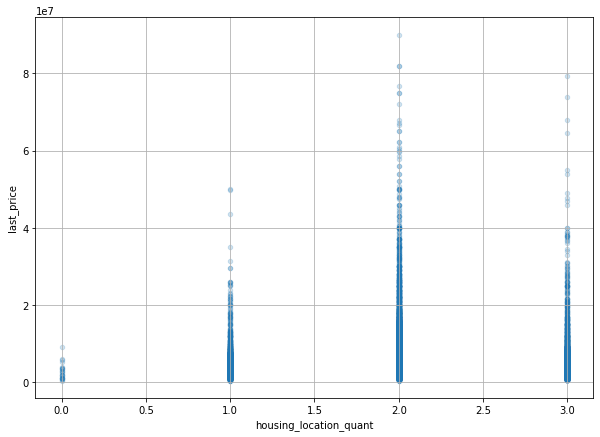

In [183]:
# Посмотрим величину корреляции Пирсона и диаграмму разброса рассматриваемых значений.

print('Корреляция Пирсона между стоимостью жилья и {} составляет {:.2%}'.format('housing_location', data_filtered['housing_location_quant'].corr(data_filtered['last_price'])))
data_filtered.plot(x='housing_location_quant', y='last_price', kind='scatter', alpha=0.2, grid=True, figsize=(10,7))
plt.show()

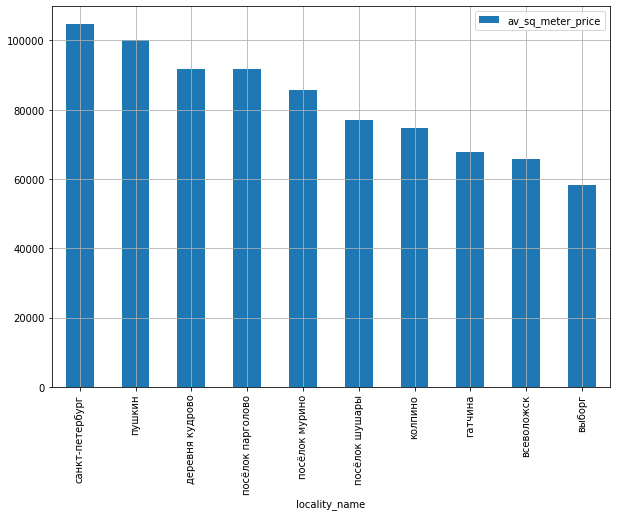

In [184]:
# Зависимости между стоимостью жилья и его этажным расположением нет. 
# Проверим среднюю цену квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и посмотрим на распределение
# по ним.

sq_meter_price_distribution = data_filtered.groupby('locality_name').agg({'locality_name':'count', 'sq_meter_price':'median'})
sq_meter_price_distribution.columns = ['count', 'av_sq_meter_price']
sq_meter_price_distribution.sort_values('count', 
                        ascending=False).head(10).sort_values(by='av_sq_meter_price', 
                        ascending=False).plot(kind='bar', y='av_sq_meter_price', grid=True, figsize=(10,7))
plt.show()

Как видно из графика, наибольшая стоимость за квадратный метр в областной столице - Санкт-Петербурге, порядка 105 тыс.руб.
Затем идет город Пушкин - 100 тыс.руб. Как ни странно, но в деревне Кудрово стоимость квадратного метра составляет порядка
92 тыс.руб - интересно, там продают элитные дома из лиственницы ? Далее идут поселки Парголово, Мурино и Шушары со средней
стоимостью квадрата 77...92 тыс.руб. - также, мягко говоря, не дешево. Города Колпино, Гатчина, Всеволожск и Выборг 
замыкают топ-10 со средним ценником 58...75 тыс.руб.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


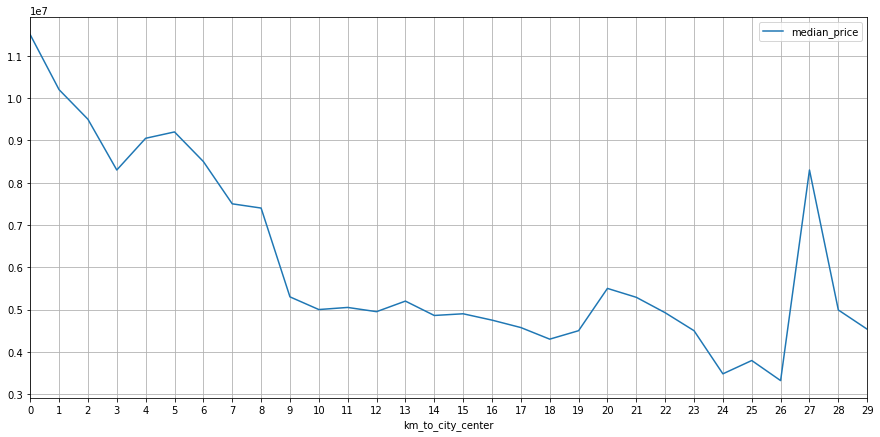

In [185]:
# Теперь выясним, какая территория входит в центр Санкт-Петербурга. Для этого отфильтруем датасет по жилью в данном городе,
# после этого посмотрим по удаленности на распределение средней стоимости на жилье.

sankt_peter = data_filtered.query('locality_name == "санкт-петербург"')
sankt_peter['km_to_city_center'] = (sankt_peter['cityCenters_nearest']/1000).round(0)
sankt_peter_grp = sankt_peter.groupby('km_to_city_center').agg({'last_price':'median'})
sankt_peter_grp.columns = ['median_price']
sankt_peter_grp.plot(y='median_price', grid=True, figsize=(15,7), xticks=range(0,30,1))
plt.show()

In [190]:
# Центром Санкт-Петербурга можно считать площадь круга радиусом 8 км. Далее идет значительное снижение стоимости (примерно на
# 30%) с равномерным распределением цен до расстояния 15 км. Затем наблюдаются различные колебания цены (как падение, так и 
# рост и непонятный скачок примерно в 2.5 раза на расстоянии 27 км. Может быть рядом аэропорт ? Проверим.

sankt_peter.query('km_to_city_center == 27')[['last_price', 'floor', 'total_area', 'sq_meter_price', 'airports_nearest', 'parks_nearest', 'ponds_nearest', 'ceiling_height_consolidation']]

,last_price,floor,total_area,sq_meter_price,airports_nearest,parks_nearest,ponds_nearest,ceiling_height_consolidation
748,14350000,3,74.0,193918,23888.0,1496.0,3100.0,3.1
5961,2250000,2,32.0,70312,24006.0,3100.0,3100.0,2.5


In [187]:
# Аэропорт примерно на таком же удалении, как и центр Санкт-Петербурга. На продажу было выставлено всего две квартиры, 
# но разница в цене за квадрат между ними почти в 3 раза. Выглядит подозрительно, с тем учетом, что по близости даже парков 
# с водоемами нет. Может, конечно, дело в высоте потолков (3.1 м) и дорогой отделке..

# Проанализируем параметры квартир, расположенных в центре - площади, цены, количество комнат, высоту потолков. Проверим
# наличие корреляций между стоимостью таких квартир и числом комнат, этажом расположения, удаленностью от центра, датой
# датой размещения объявления. Создадим новую переменную с параметрами квартир, находящихся в центре Санкт-Петербурга.

sankt_peter_center = sankt_peter.query('km_to_city_center <= 8')

In [216]:
# Посмотрим на численное описание интересующих нас параметров.

parameters_to_describe = ['total_area', 'last_price', 'rooms', 'ceiling_height_consolidation']

for parameter in parameters_to_describe:
    print(sankt_peter_center[parameter].describe(), sep='\n')

count    3958.000000
mean       83.438936
std        40.958061
min        12.000000
25%        54.000000
50%        75.000000
75%       102.000000
max       300.000000
Name: total_area, dtype: float64
count    3.958000e+03
mean     1.140123e+07
std      8.871111e+06
min      1.600000e+06
25%      6.350000e+06
50%      8.700000e+06
75%      1.300000e+07
max      9.000000e+07
Name: last_price, dtype: float64
count    3958.000000
mean        2.654876
std         1.224854
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         7.000000
Name: rooms, dtype: float64
count    3958.000000
mean        3.022107
std         0.352275
min         2.400000
25%         2.725000
50%         3.000000
75%         3.300000
max         4.500000
Name: ceiling_height_consolidation, dtype: float64


In [215]:
# Всего представлено 3958 наблюдений. Общая площадь жилья находится в диапазоне 12...300 м2. Q1, Q2 и Q3 соответственно равны
# 54, 75 и 102 м2. Достаточно просторные квартиры. Общая цена в выборке колеблется от 1.6 до 90.0 млн.руб. Нижний ценовой 
# сегмент достаточно доступный по сегодняшним меркам. Посмотрим на параметры самых просторных квартир, продаваемых дешевле 
# 3 млн.руб.

sankt_peter_center.query('last_price < 3000000').sort_values(by='total_area', ascending=False)[['last_price', 'sq_meter_price', 'total_area', 'living_area', 'days_exposition']].head(10)

,last_price,sq_meter_price,total_area,living_area,days_exposition
19952,2200000,15861,138.70,90.7,203
17753,1800000,15345,117.30,23.6,139
23394,1600000,17391,92.00,13.0,3
13739,2100000,26250,80.00,23.0,23
23606,2850000,41911,68.00,41.0,4
5182,2750000,72178,38.10,14.1,121
9221,2850000,79320,35.93,15.0,20
17290,2800000,82352,34.00,17.7,62
8381,2820000,88125,32.00,20.0,62
3883,2800000,88888,31.50,23.9,13


Вообще параметры и стоимость первых четырех квартир вызывает вопросы. Квартира ценой 2.2 млн.руб. площадью 139 м2 в центре
Питера? И продается более полугода. Что-то с ней было не то - может аварийное состояние дома. У следующей квартиры жилая
площадь всего 24 из 117 м2 - интересная конфигурация. Анализируя представленный датасет можно хорошо изучить архитектурное 
наследие славного города. Ну да ладно, у нас нет цели собрать коллекцию квартирных планировок. При этом остается фактом 
наличие объявлений, вызывающих вопросы.

С количеством комнат все более понятно - в среднем 3, что объяснимо для квартир в центральной части города. По высоте 
потолков среднее значение такое же - можно спокойно превращать его в разноуровневый.

Корреляция Пирсона между стоимостью жилья и total_area составляет 73.96%


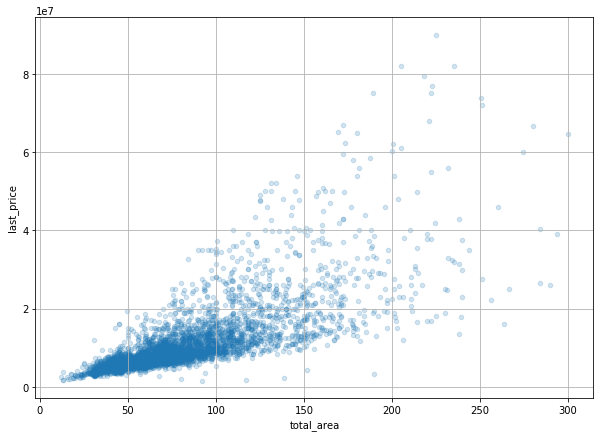

Корреляция Пирсона между стоимостью жилья и living_area составляет 63.05%


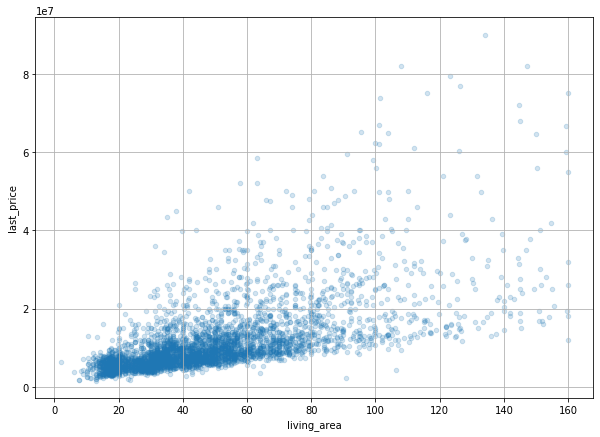

Корреляция Пирсона между стоимостью жилья и kitchen_area составляет 52.78%


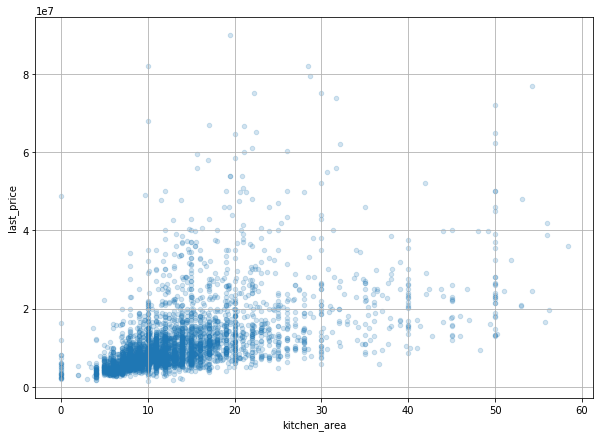

Корреляция Пирсона между стоимостью жилья и rooms составляет 44.37%


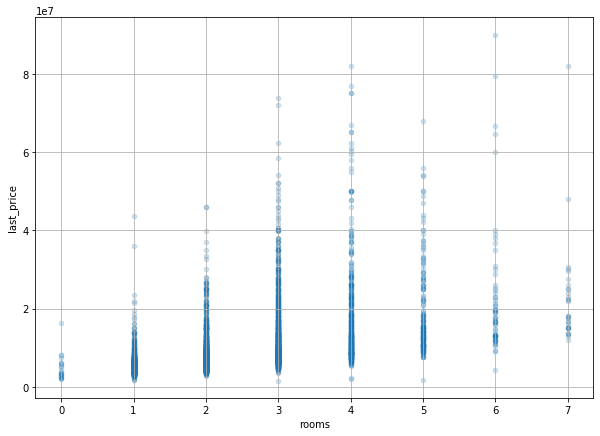

Корреляция Пирсона между стоимостью жилья и cityCenters_nearest составляет -7.58%


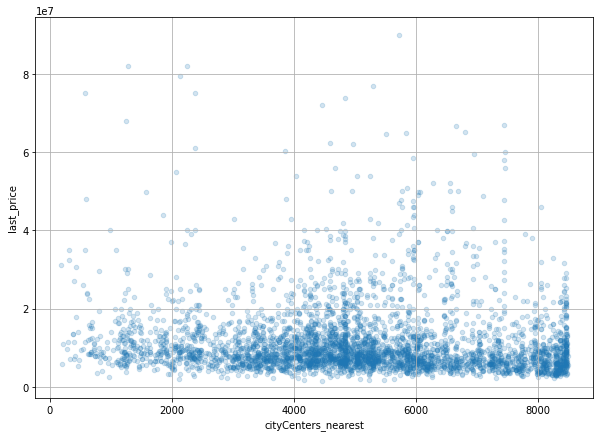

Корреляция Пирсона между стоимостью жилья и housing_location_quant составляет 8.64%


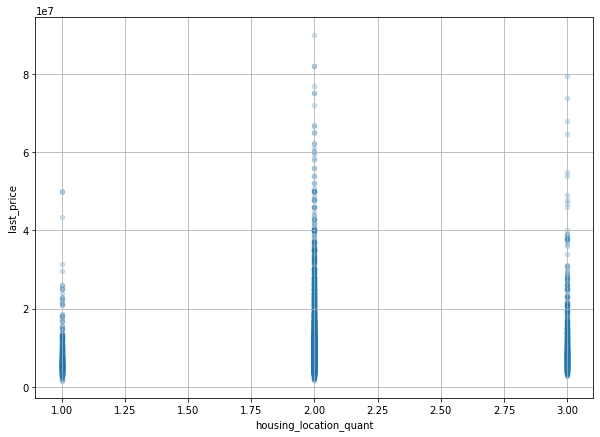

Корреляция Пирсона между стоимостью жилья и exposition_weekday составляет -0.82%


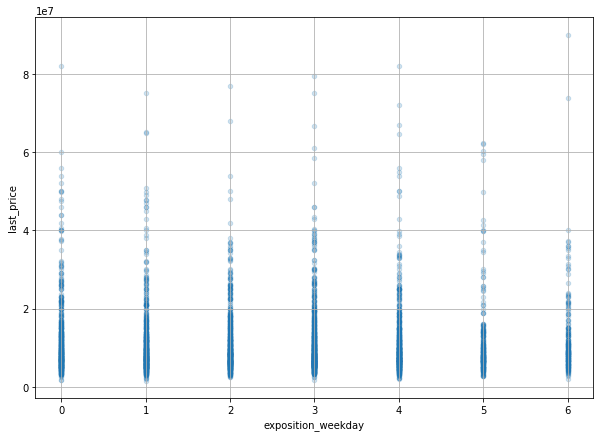

Корреляция Пирсона между стоимостью жилья и exposition_month составляет -1.80%


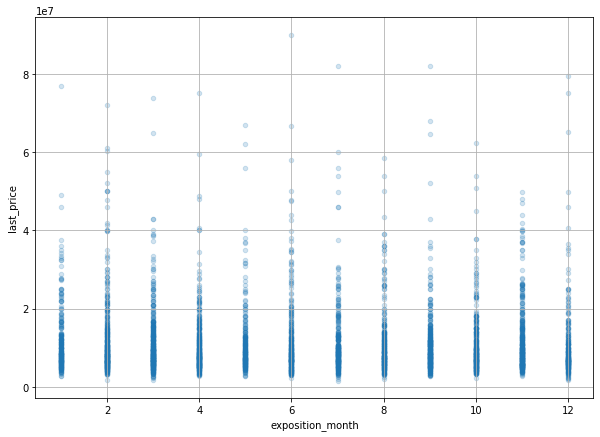

Корреляция Пирсона между стоимостью жилья и exposition_year составляет -6.46%


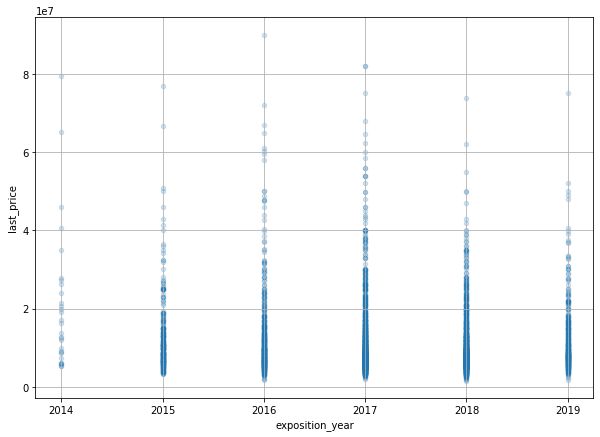

In [221]:
# Переходим к определению факторов, оказывающих наибольшее влияние на стоимость жилья в центре Питера. Рассмотрим те же, что 
# и для обычного жилья - количество квадратных метров (общая площадь, жилая и кухонная), число комнат, удаленность от центра,
# этаж расположения (варианты: первый, другой и последний), дата размещения публикации (день недели, месяц, год).

evaluated_factors = ['total_area', 'living_area', 'kitchen_area', 
                     'rooms', 'cityCenters_nearest', 'housing_location_quant',
                     'exposition_weekday', 'exposition_month', 'exposition_year'
                     ]

for factor in evaluated_factors:

    print('Корреляция Пирсона между стоимостью жилья и {} составляет {:.2%}'.format(factor, sankt_peter_center[factor].corr(sankt_peter_center['last_price'])))
    sankt_peter_center.plot(x=factor, y='last_price', kind='scatter', alpha=0.2, grid=True, figsize=(10,7))
    plt.show()

Итак, результаты:

- наибольшая корреляция цены жилья с её общей площадью (74.0);
- с жилой и кухонной площадями корреляция средняя - 63.1 и 52.8% соответственно;
- зависимость с количеством комнат слабая и составляет 44.4%;
- условная удаленность от центра для таких квартир также не является фактором в ценообразовании жилья - корреляция минус 7.6%;
- зависимости между стоимостью жилья и его этажным расположением нет;
- от времени размещения объявления о продаже жилья его стоимость никак не зависит.

В целом зависимость цены от рассмотренных параметров чуть меньше, чем для остального жилья. Наибольшая корреляция с общей
площадью квартиры, таким образом она является ключевым фактором в ценообразовании жилья.

### Вывод

В подготовленном датасете изучены следующие параметры - площадь, цена, число комнат и высота потолков:

- общая площадь помещений находится в диапазоне 12...900 м2. Медиана равна 52 м2, среднее порядка 60 м2 - т.о., значение 900 м2 является нетипичным и завышает среднее.

- цена находится в диапазоне 0.012...763 млн.руб. Разбег гигантский, это видно и по стандартному отклонению - 10.9 млн.руб. при значении Q3 равном 6.8 млн.руб. Медиана равна 4.65 млн.руб, среднее порядка 6.5 млн.руб - т.о., значение 763 млн.руб. является нетипичным и завышает среднее. Минимальное значение также подозрительное - жилье не может стоить 12 тыс.руб.

- количество комнат находится в диапазоне 0...19. Значение 0 является подозрительным, возможно, оно соответствует однокомнатной квартире-студии. Медиана равна 2, среднее также порядка 2, соответственно, разброс значений небольшой, стандартное отклонение порядка 1.

- высота потолков находится в диапазоне 2.2...4.5 м. Данный диапазон получился после обработки пропусков и выбросов. Медиана равна 2.6 м, среднее также порядка 2.7 м, соответственно, разброс значений небольшой, стандартное отклонение порядка 0.3 м.

Также убраны выбросы, заменены / удалены артефакты. В итоге подготовленный датасет за счет удаления явных выбросов уменьшился на 0.95 %.
Проанализированы факторы на предмет влияния на стоимость жилья для всего датасета, выводы следующие:

- наибольшая корреляция цены жилья с её общей площадью (77.8%);

- с жилой и кухонной площадями корреляция средняя - 68.3 и 60.0% соответственно;

- зависимость с количеством комнат слабая и составляет 48.1%;

- удаленность от центра также не является определяющим фактором в ценообразовании жилья - корреляция минус 31.9%;

- зависимости между стоимостью жилья и его этажным расположением нет;

- от времени размещения объявления о продаже жилья его стоимость никак не зависит.

Проведена оценка средней стоимости за квадратный метр по населенным пунктам. Наибольшая стоимость в областной столице - Санкт-Петербурге, порядка 105 тыс.руб. Затем идет город Пушкин - 100 тыс.руб. В деревне Кудрово стоимость квадратного метра составляет порядка 92 тыс.руб – странное значение. Далее идут поселки Парголово, Мурино и Шушары со средней стоимостью квадрата 77...92 тыс.руб. - также, мягко говоря, не дешево. Города Колпино, Гатчина, Всеволожск и Выборг замыкают топ-10 со средним ценником 58...75 тыс.руб.
Определен условный центр Санкт-Петербурга, цена жилья за которым значительно снижается (примерно на 30%) – это территория радиусом 8 км. Для данного района зависимость цены от факторов, с которыми определялась корреляция стоимости всего жилья в датасете, чуть меньше, чем для остального жилья. Наибольшая корреляция с общей площадью квартиры, т.о. она является ключевым фактором в ценообразовании жилья.
Также обнаружены странные объявления с крайне низкими ценами за большие квартиры в центре областной столицы и крайне высокими ценами за квартиры средней площади и не относящимися к центру города.

### Шаг 5. Общий вывод

Исходный датасет состоял из 23699 наблюдений и 22 признаков, из которых 2 с булевыми значениями, по 3 с целочисленными и объектными. Больше всего признаков с вещественным типом данных - целых 14.

Пропуски в исходном датасете присутствовали в 14 из 22 столбцах – количество пропусков варьировалось от 0.2 до 88.3%. Наибольшее из них присутствовало в столбце 'is_apartment'. Для их заполнения проведено сравнение параметров апартаментов (50 ед.) и неапартаментов (2725 ед.), выявлены характерные для апартаментов признаки, в которых также присутствовали пропуски. По итогам их заполнения можно сделать следующие выводы:

• в датасете имеются неслучайные пропуски в столбцах, связанных с измерением расстояния до различных объектов либо с подсчетом количества объектов в радиусе 3 км ('airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest', 'parks_around3000', 'ponds_around3000') и характерны для 345 населенных пунктов из 364 – эти пропуски связаны с ошибкой автоматизации выгрузки картографических данных и оставлены без изменений;

• остальные пропуски заполнены на основе анализа разброса значений и наличия корреляций с другими признаками либо при помощи логического умозаключения о связи пропусков и отсутствия признака (значение 0).


Дубликаты в датасете не обнаружены. В столбцах 'last_price', 'floors_total', 'balcony', 'days_exposition' тип данных изменен с вещественного на целочисленный. Для части столбцов был оставлен вещественный тип по причине присутствия пропусков (не заполнялись и не удалялись для сохранения остальных признаков со значениями).

В датасет добавлена следующая информация:

•	цена квадратного метра;

•	день недели, месяц и год публикации;

•	вариант размещения жилья на этаже (первый этаж, один этаж, другой этаж и последний);

•	отношение жилой площади к общей и кухонной к общей.


В подготовленном датасете изучены следующие параметры - площадь, цена, число комнат и высота потолков:

•	общая площадь помещений находится в диапазоне 12...900 м2. Медиана равна 52 м2, среднее порядка 60 м2 - т.о., значение 900 м2 является нетипичным и завышает среднее.

•	цена находится в диапазоне 0.012...763 млн.руб. Разбег гигантский, это видно и по стандартному отклонению - 10.9 млн.руб. при значении Q3 равном 6.8 млн.руб. Медиана равна 4.65 млн.руб, среднее порядка 6.5 млн.руб - т.о., значение 763 млн.руб. является нетипичным и завышает среднее. Минимальное значение также подозрительное - жилье не может стоить 12 тыс.руб.

•	количество комнат находится в диапазоне 0...19. Значение 0 является подозрительным, возможно, оно соответствует однокомнатной квартире-студии. Медиана равна 2, среднее также порядка 2, соответственно, разброс значений небольшой, стандартное отклонение порядка 1.

•	высота потолков находится в диапазоне 2.2...4.5 м. Данный диапазон получился после обработки пропусков и выбросов. Медиана равна 2.6 м, среднее также порядка 2.7 м, соответственно, разброс значений небольшой, стандартное отклонение порядка 0.3 м.


Также убраны выбросы, заменены / удалены артефакты. В итоге подготовленный датасет за счет удаления явных выбросов уменьшился на 0.95 %. Проанализированы факторы на предмет влияния на стоимость жилья для всего датасета, выводы следующие:

•	наибольшая корреляция цены жилья с её общей площадью (77.8%);

•	с жилой и кухонной площадями корреляция средняя - 68.3 и 60.0% соответственно;

•	зависимость с количеством комнат слабая и составляет 48.1%;

•	удаленность от центра также не является определяющим фактором в ценообразовании жилья - корреляция минус 31.9%;

•	зависимости между стоимостью жилья и его этажным расположением нет;

•	от времени размещения объявления о продаже жилья его стоимость никак не зависит.

Проведена оценка средней стоимости за квадратный метр по населенным пунктам. Наибольшая стоимость в областной столице - Санкт-Петербурге, порядка 105 тыс.руб. Затем идет город Пушкин - 100 тыс.руб. В деревне Кудрово стоимость квадратного метра составляет порядка 92 тыс.руб – странное значение. Далее идут поселки Парголово, Мурино и Шушары со средней стоимостью квадрата 77...92 тыс.руб. - также, мягко говоря, не дешево. Города Колпино, Гатчина, Всеволожск и Выборг замыкают топ-10 со средним ценником 58...75 тыс.руб. Определен условный центр Санкт-Петербурга, цена жилья за которым значительно снижается (примерно на 30%) – это территория радиусом 8 км. Для данного района зависимость цены от факторов, с которыми определялась корреляция стоимости всего жилья в датасете, чуть меньше, чем для остального жилья. Наибольшая корреляция с общей площадью квартиры, т.о. она является ключевым фактором в ценообразовании жилья. Также обнаружены странные объявления с крайне низкими ценами за большие квартиры в центре областной столицы и крайне высокими ценами за квартиры средней площади и не относящимися к центру города.

============================================================================================================================
Таким образом, наибольшее влияние на ценообразование жилья оказывает его общая площадь. При этом в перечне объявлений имеются варианты с крайне высокими и крайне низкими ценами, не соответствующими характеристикам жилья. В среднем продажа квартиры занимает от одного до семи месяцев, но есть случаи закрытия объявления за несколько дней и не закрытия вообще (продолжительность размещения таких объявлений 4+ лет).

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод